<a href="https://colab.research.google.com/github/ammarkhan98/Thesis-Utilizing-Neural-Networks-on-Infectious-Disease-Outbreak-Detection/blob/Research/Research_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# 1. Download the dataset from the same source
url = "https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/vaccinations.csv"
response = requests.get(url)
data = pd.read_csv(StringIO(response.text))

In [2]:
data.shape

(196246, 16)

In [3]:
# 2. Data Preprocessing
# Fill missing values with forward fill (for time series continuity) and drop rows where critical columns are still missing
df = data[['date', 'location', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'daily_vaccinations']].ffill().dropna()

# Convert date to datetime and extract the day of the year as a numerical feature
df['date'] = pd.to_datetime(df['date'])
df['day_of_year'] = df['date'].dt.dayofyear

# Features and target
features = df[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']]
target = df['daily_vaccinations']

In [4]:
df.head()

date     location  total_vaccinations  people_vaccinated  \
78 2021-05-11  Afghanistan            504502.0           448878.0   
79 2021-05-12  Afghanistan            504502.0           448878.0   
80 2021-05-13  Afghanistan            504502.0           448878.0   
81 2021-05-14  Afghanistan            504502.0           448878.0   
82 2021-05-15  Afghanistan            504502.0           448878.0   

    people_fully_vaccinated  daily_vaccinations  day_of_year  
78                  55624.0             13921.0          131  
79                  55624.0             12621.0          132  
80                  55624.0             11321.0          133  
81                  55624.0             10022.0          134  
82                  55624.0              8722.0          135

In [ ]:
# create a data frame that just contain locations which are countries (not a continent or area)

#df_countries = df[~df['location'].isin(['World', 'Asia', 'Europe', 'European Union', 'North America', 'South America', 'Africa', 'Oceania'])]

In [5]:
#create dataset that just contains data for continents

df_continents = df[df['location'].isin(['World', 'Asia', 'Europe', 'European Union', 'North America', 'South America', 'Africa', 'Oceania'])]

In [6]:
df_continents

date location  total_vaccinations  people_vaccinated  \
1043   2021-01-09   Africa        0.000000e+00       0.000000e+00   
1044   2021-01-10   Africa        0.000000e+00       0.000000e+00   
1045   2021-01-11   Africa        0.000000e+00       0.000000e+00   
1046   2021-01-12   Africa        0.000000e+00       0.000000e+00   
1047   2021-01-13   Africa        2.000000e+03       2.000000e+03   
...           ...      ...                 ...                ...   
193893 2024-08-10    World        1.357876e+10       5.631264e+09   
193894 2024-08-11    World        1.357877e+10       5.631264e+09   
193895 2024-08-12    World        1.357877e+10       5.631264e+09   
193896 2024-08-13    World        1.357877e+10       5.631264e+09   
193897 2024-08-14    World        1.357877e+10       5.631264e+09   

        people_fully_vaccinated  daily_vaccinations  day_of_year  
1043               1.837039e+07                 0.0            9  
1044               1.837039e+07               500.0           10  
1045               1.837039e+07               500.0           11  
1046               1.837039e+07               500.0           12  
1047               1.837039e+07               500.0           13  
...                         ...                 ...          ...  
193893             5.177943e+09              1340.0          223  
193894             5.177943e+09              1340.0          224  
193895             5.177943e+09              1340.0          225  
193896             5.177943e+09              1340.0          226  
193897             5.177943e+09              1340.0          227  

[10217 rows x 7 columns]

from matplotlib import pyplot as plt
df_continents['total_vaccinations'].plot(kind='hist', bins=20, title='total_vaccinations')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_continents['people_vaccinated'].plot(kind='hist', bins=20, title='people_vaccinated')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_continents['people_fully_vaccinated'].plot(kind='hist', bins=20, title='people_fully_vaccinated')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_continents['daily_vaccinations'].plot(kind='hist', bins=20, title='daily_vaccinations')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_continents.groupby('location').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_continents.plot(kind='scatter', x='total_vaccinations', y='people_vaccinated', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_continents.plot(kind='scatter', x='people_vaccinated', y='people_fully_vaccinated', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_continents.plot(kind='scatter', x='people_fully_vaccinated', y='daily_vaccinations', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_continents.plot(kind='scatter', x='daily_vaccinations', y='day_of_year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['total_vaccinations']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_continents.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('location')):
  _plot_series(series, series_name, i)
  fig.legend(title='location', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('total_vaccinations')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['people_vaccinated']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_continents.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('location')):
  _plot_series(series, series_name, i)
  fig.legend(title='location', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('people_vaccinated')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['people_fully_vaccinated']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_continents.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('location')):
  _plot_series(series, series_name, i)
  fig.legend(title='location', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('people_fully_vaccinated')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['daily_vaccinations']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_continents.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('location')):
  _plot_series(series, series_name, i)
  fig.legend(title='location', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('daily_vaccinations')

from matplotlib import pyplot as plt
df_continents['total_vaccinations'].plot(kind='line', figsize=(8, 4), title='total_vaccinations')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_continents['people_vaccinated'].plot(kind='line', figsize=(8, 4), title='people_vaccinated')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_continents['people_fully_vaccinated'].plot(kind='line', figsize=(8, 4), title='people_fully_vaccinated')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_continents['daily_vaccinations'].plot(kind='line', figsize=(8, 4), title='daily_vaccinations')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_continents['location'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_continents, x='total_vaccinations', y='location', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_continents['location'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_continents, x='people_vaccinated', y='location', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_continents['location'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_continents, x='people_fully_vaccinated', y='location', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_continents['location'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_continents, x='daily_vaccinations', y='location', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

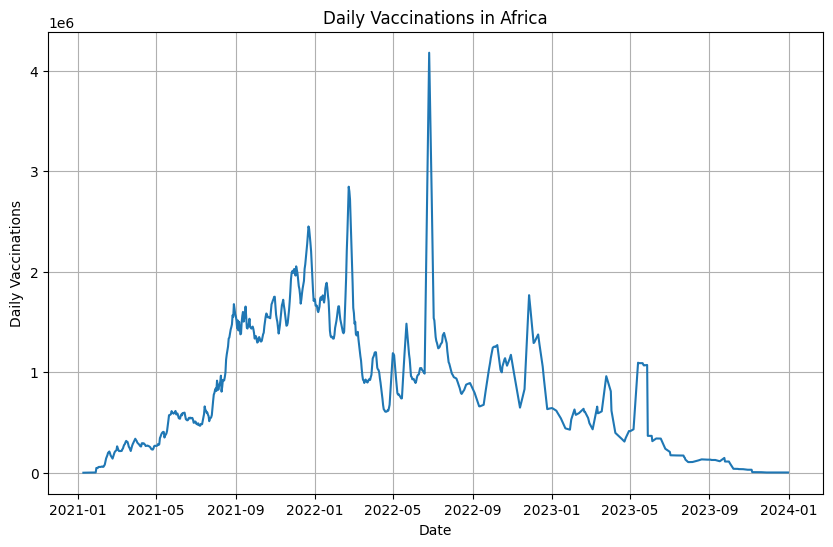

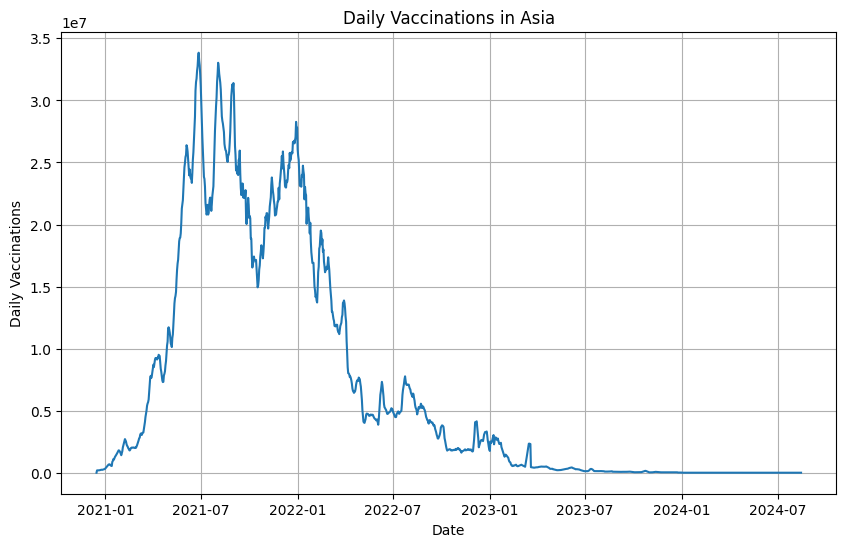

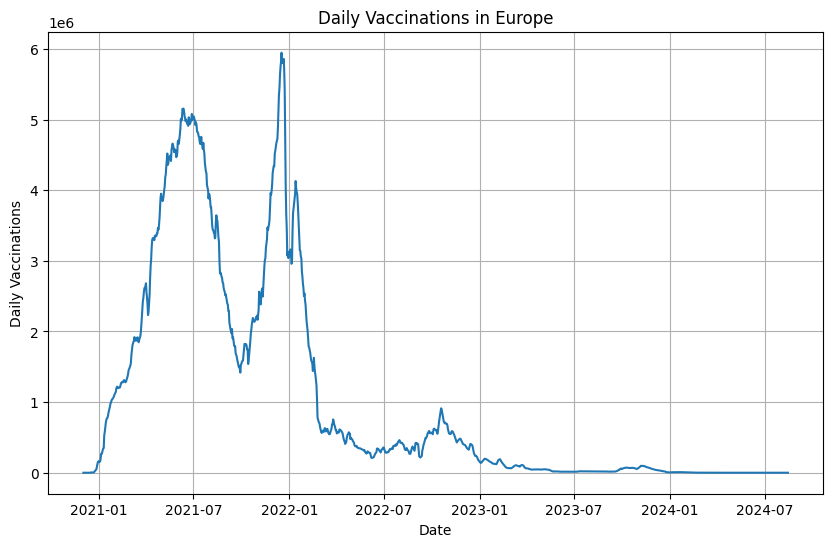

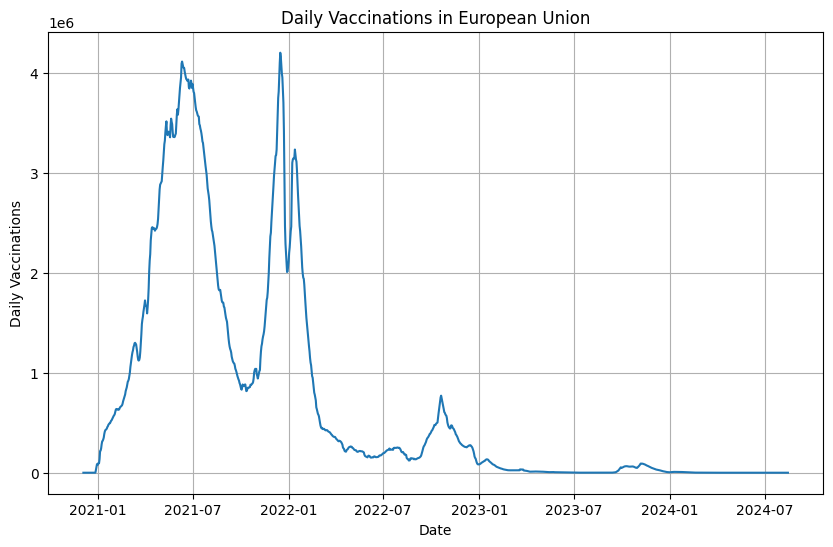

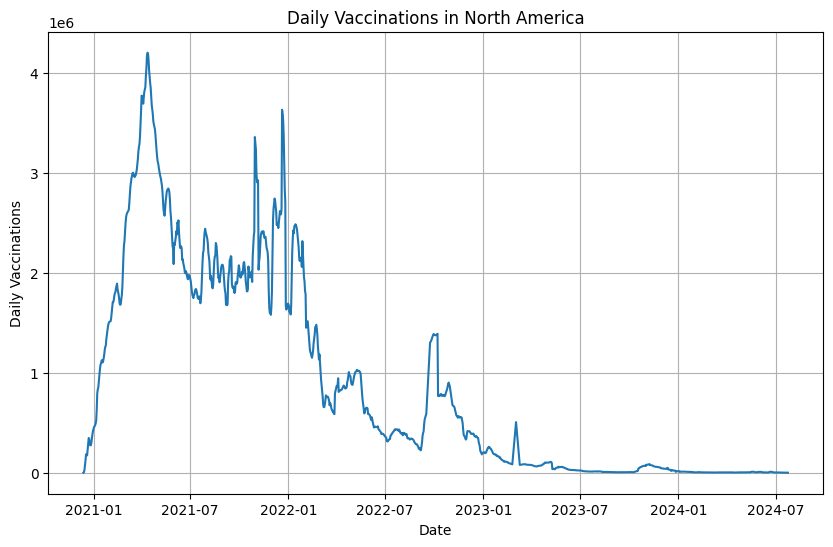

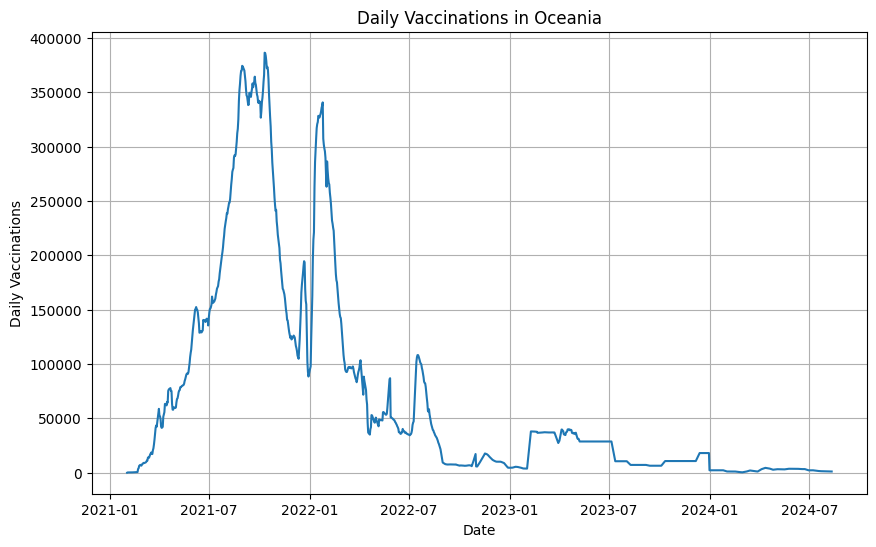

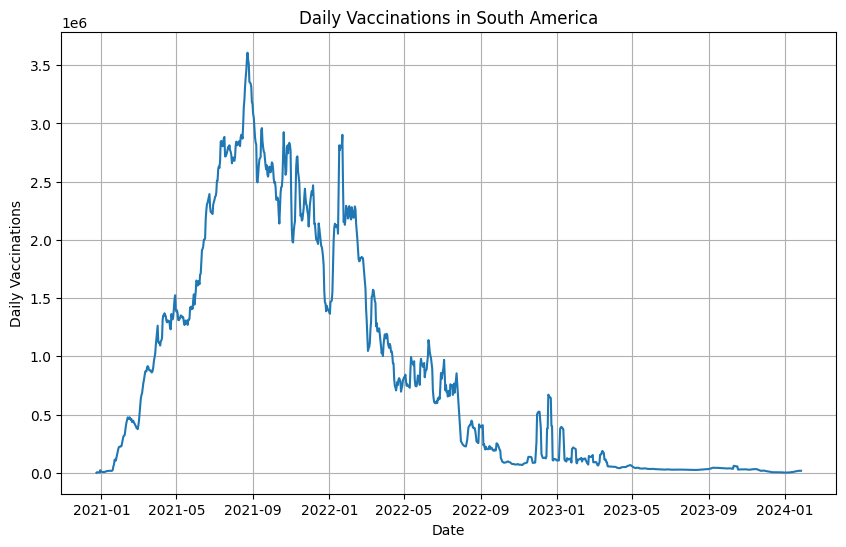

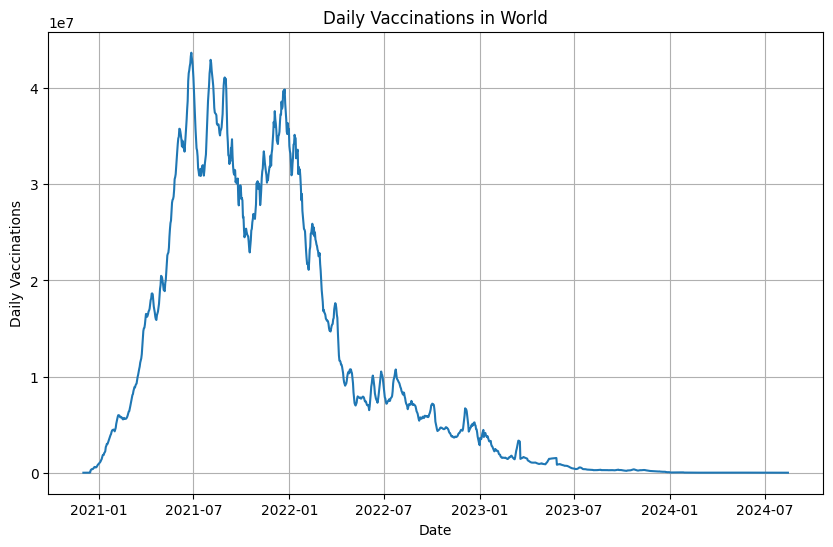

In [ ]:
#show graph of each continent for daily vaccinations

import matplotlib.pyplot as plt

for continent in df_continents['location'].unique():
  df_continent = df_continents[df_continents['location'] == continent]
  plt.figure(figsize=(10, 6))
  plt.plot(df_continent['date'], df_continent['daily_vaccinations'])
  plt.title(f'Daily Vaccinations in {continent}')
  plt.xlabel('Date')
  plt.ylabel('Daily Vaccinations')
  plt.grid(True)
  plt.show()


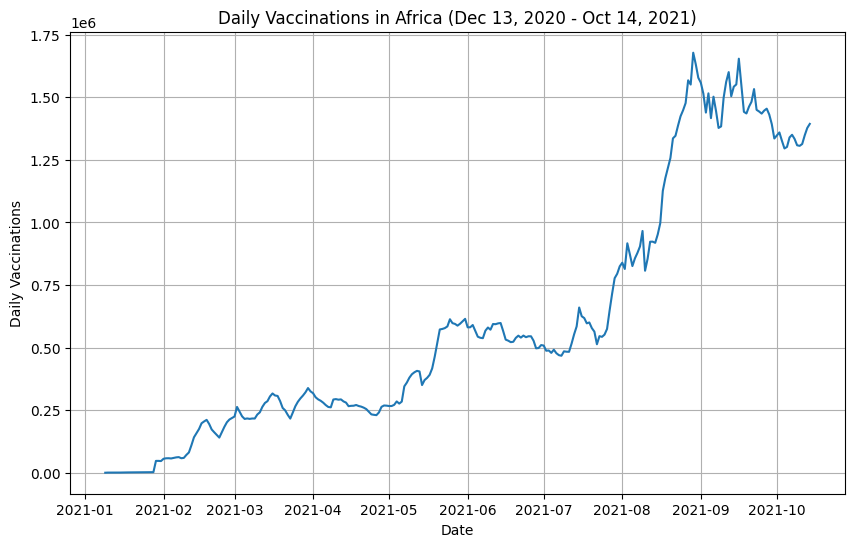

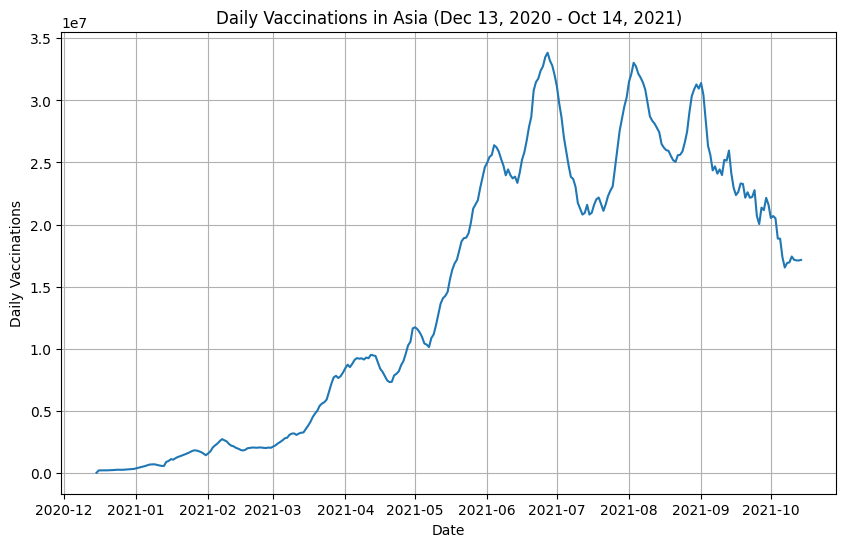

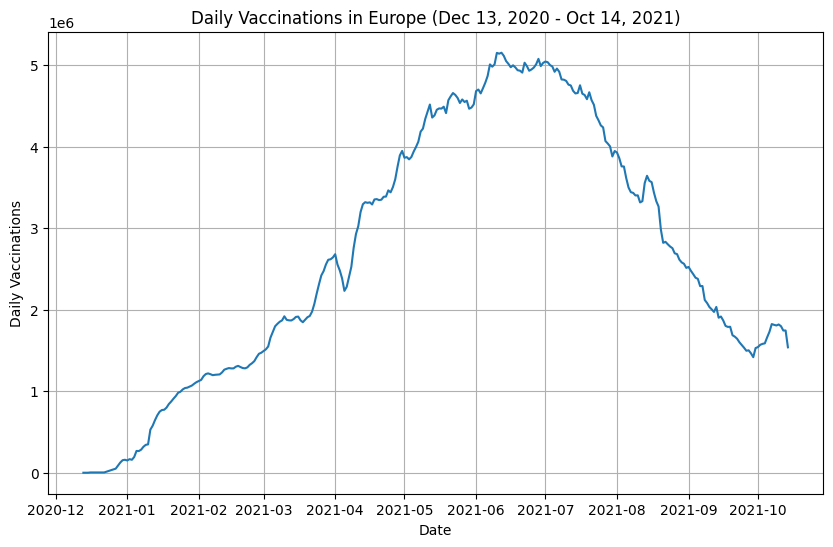

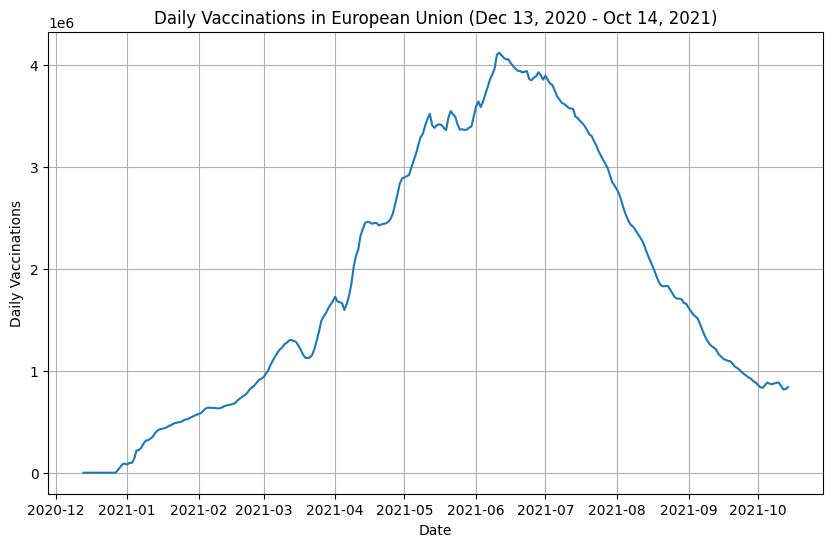

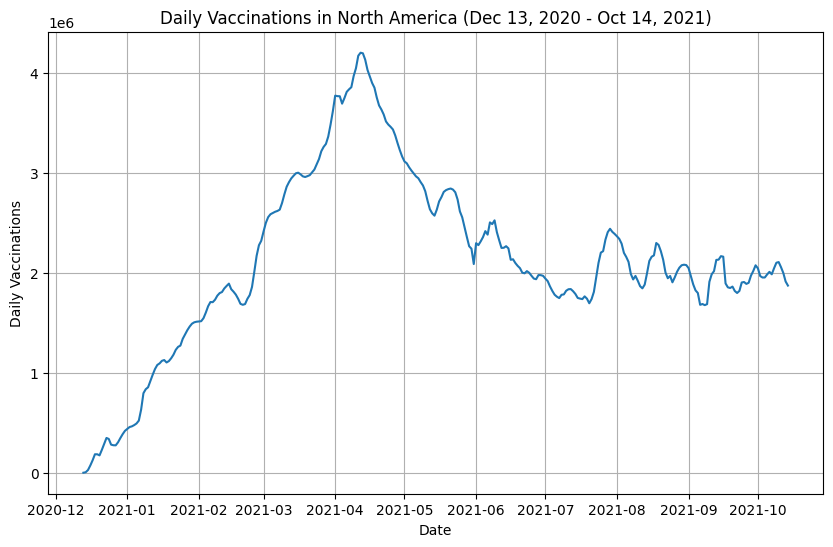

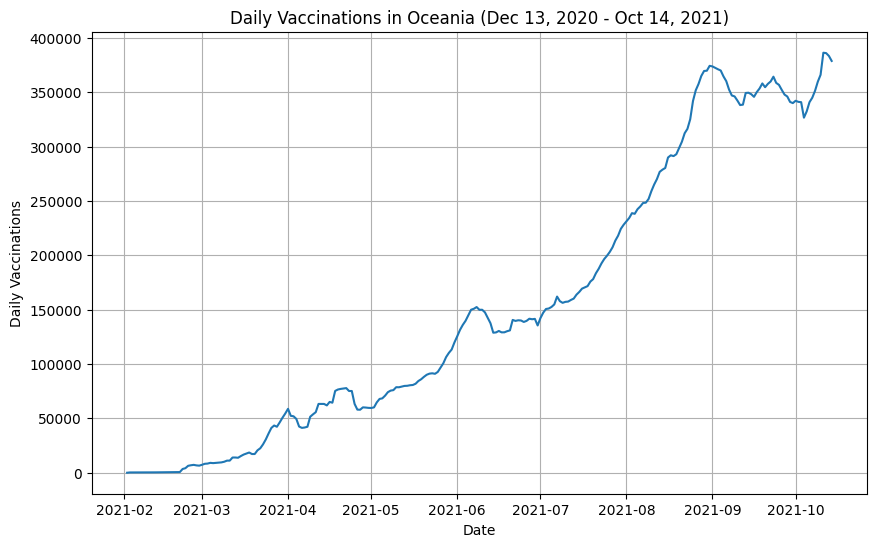

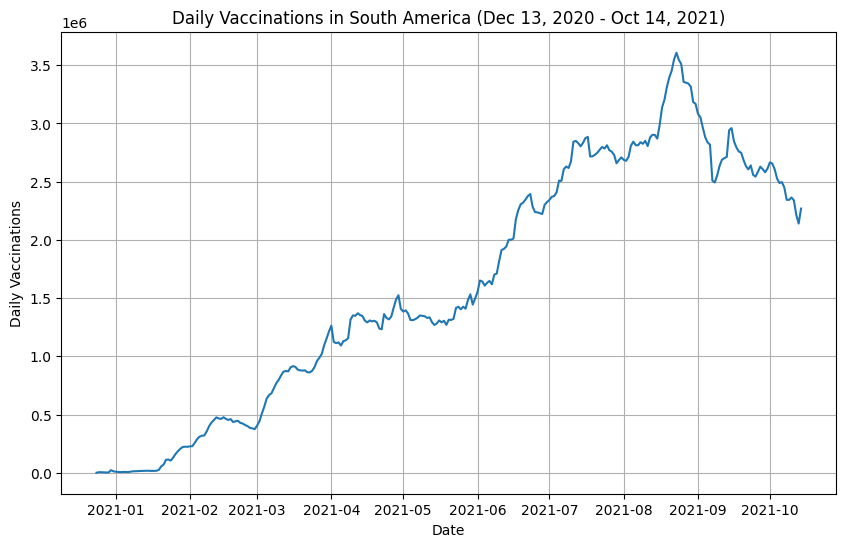

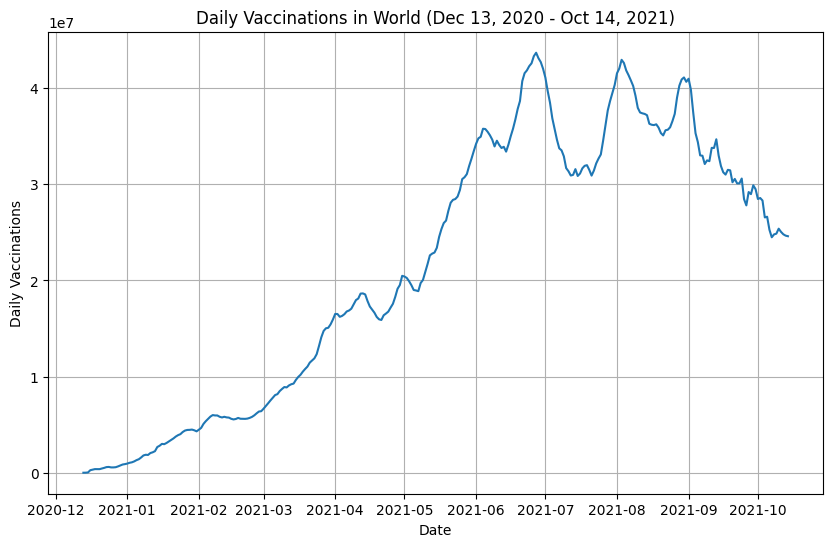

In [ ]:
#create graphs again from the 13th of December 2020 to the 14th of October 2021.

import matplotlib.pyplot as plt
for continent in df_continents['location'].unique():
  df_continent = df_continents[df_continents['location'] == continent]
  df_continent = df_continent[(df_continent['date'] >= '2020-12-13') & (df_continent['date'] <= '2021-10-14')]
  plt.figure(figsize=(10, 6))
  plt.plot(df_continent['date'], df_continent['daily_vaccinations'])
  plt.title(f'Daily Vaccinations in {continent} (Dec 13, 2020 - Oct 14, 2021)')
  plt.xlabel('Date')
  plt.ylabel('Daily Vaccinations')
  plt.grid(True)
  plt.show()

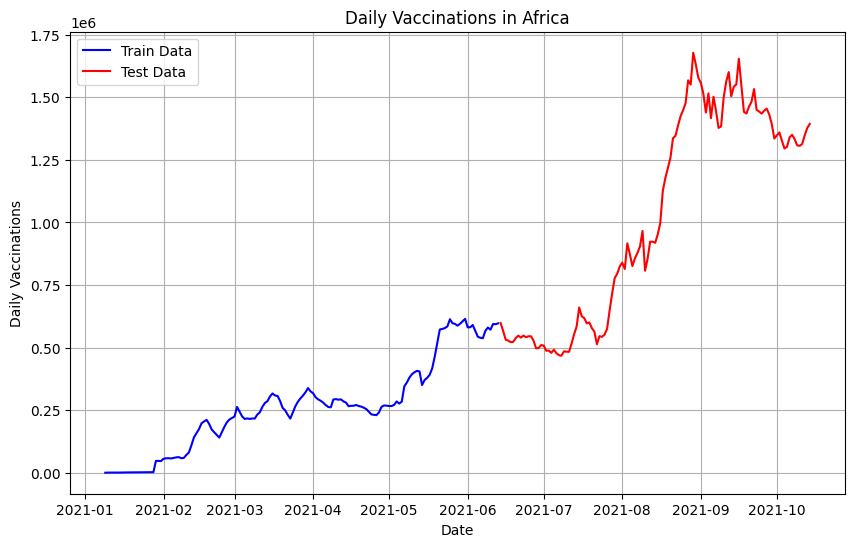

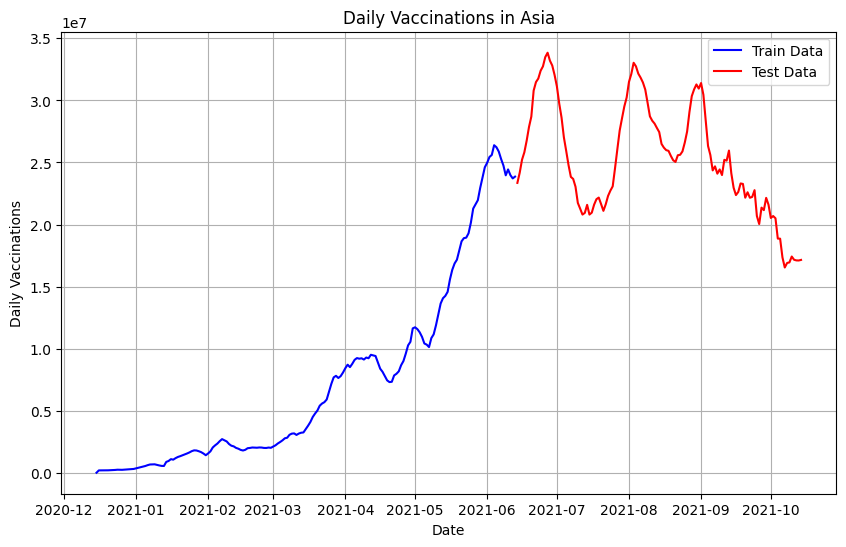

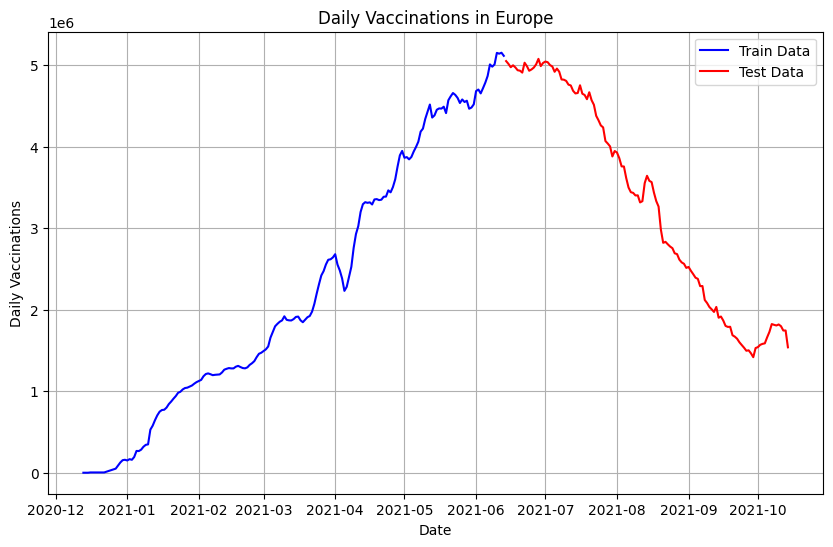

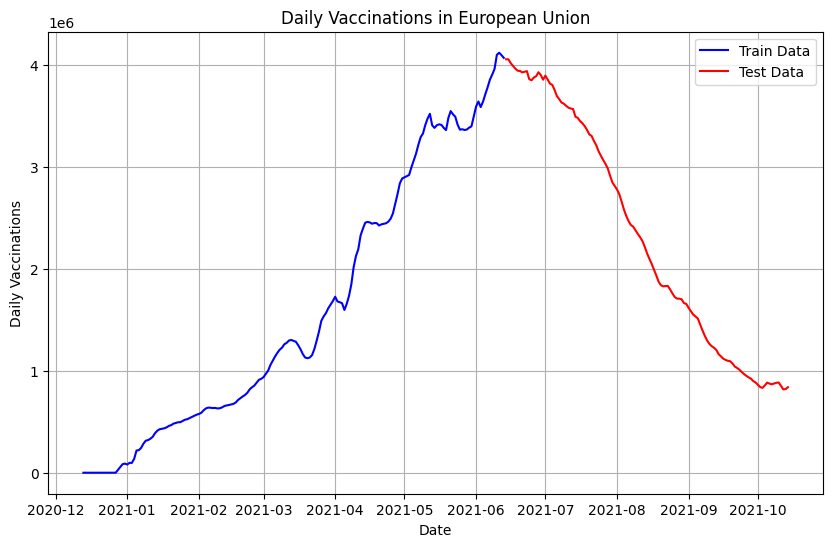

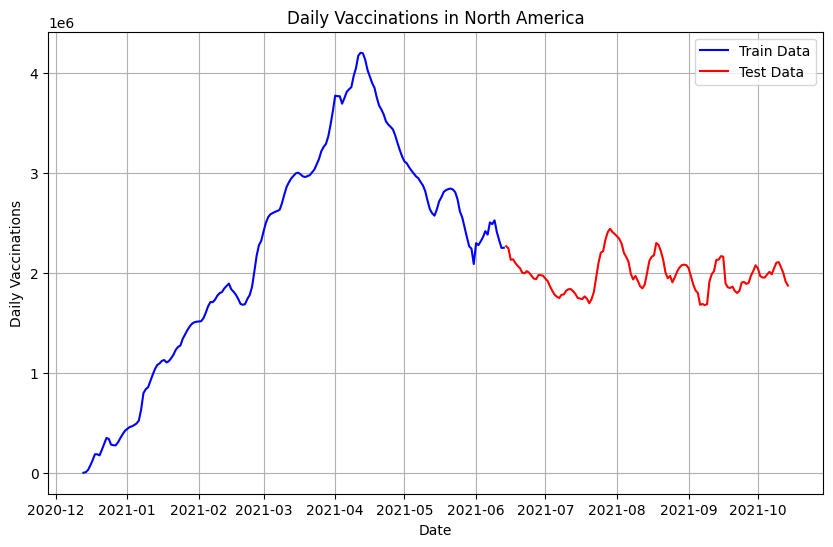

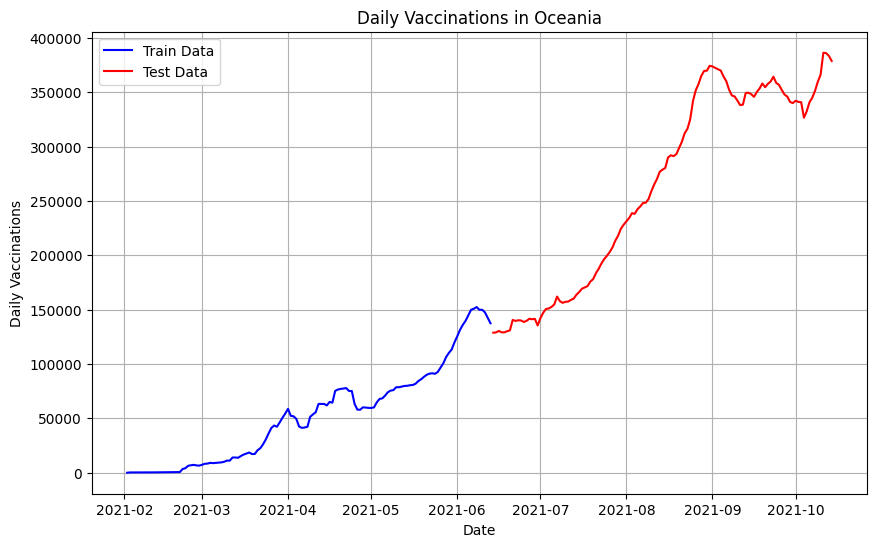

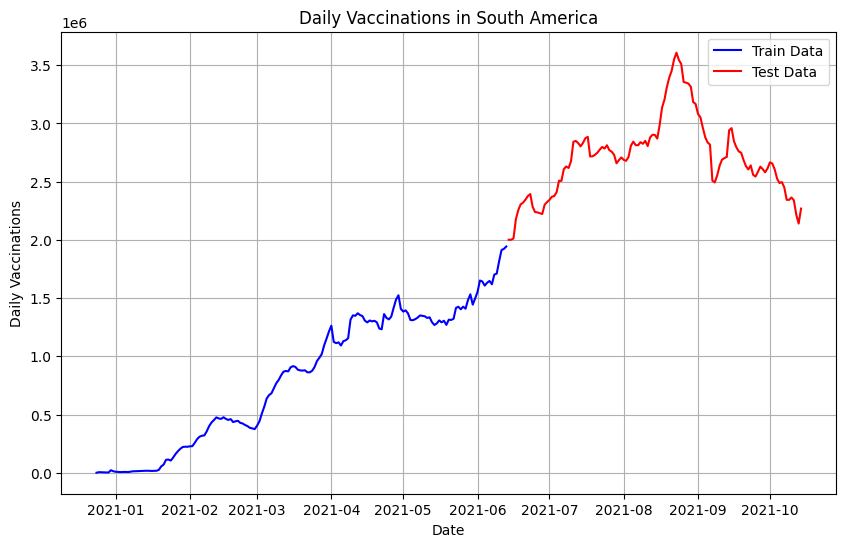

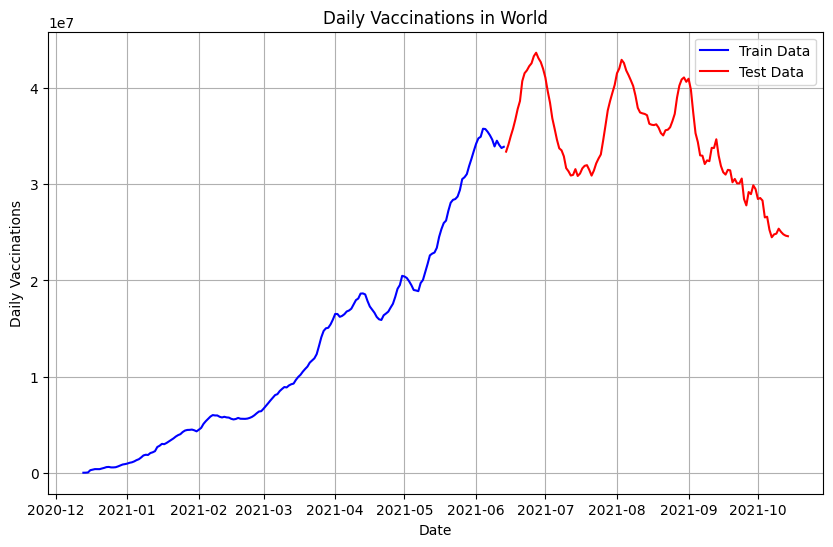

In [ ]:
#create graphs again and use different blue for daily data from the 13th of December 2020 to the 13th of June 2021,  and red from the 14th of June 2021 to the 14th of October 2021, label the blue part of graph as train data, and red part of graph as test data

import matplotlib.pyplot as plt

for continent in df_continents['location'].unique():
    df_continent = df_continents[df_continents['location'] == continent]
    plt.figure(figsize=(10, 6))

    # Filter data for the specified date ranges
    train_data = df_continent[(df_continent['date'] >= '2020-12-13') & (df_continent['date'] <= '2021-06-13')]
    test_data = df_continent[(df_continent['date'] >= '2021-06-14') & (df_continent['date'] <= '2021-10-14')]

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')


    plt.title(f'Daily Vaccinations in {continent}')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()  # Show the legend for train and test data
    plt.show()


In [ ]:
#create train and test dataframe for each continent based on 13th of December 2020 to the 13th of June 2021 as train, while the testing dataset is comprised of COVID-19 daily data from the 14th of June 2021 to the 14th of October 2021.

train_dfs = {}
test_dfs = {}

for continent in df_continents['location'].unique():
    df_continent = df_continents[df_continents['location'] == continent]

    train_data = df_continent[(df_continent['date'] >= '2020-12-13') & (df_continent['date'] <= '2021-06-13')]
    test_data = df_continent[(df_continent['date'] >= '2021-06-14') & (df_continent['date'] <= '2021-10-14')]

    train_dfs[continent] = train_data
    test_dfs[continent] = test_data

In [ ]:
#show shape of each of these train and test data for each continent separately (first world, then asia, ...) and head of each

for continent in df_continents['location'].unique():
  print(f"Continent: {continent}")
  print("Train Data Shape:", train_dfs[continent].shape)
  print("Test Data Shape:", test_dfs[continent].shape)
  print("\n")


Continent: Africa
Train Data Shape: (156, 7)
Test Data Shape: (123, 7)


Continent: Asia
Train Data Shape: (181, 7)
Test Data Shape: (123, 7)


Continent: Europe
Train Data Shape: (183, 7)
Test Data Shape: (123, 7)


Continent: European Union
Train Data Shape: (183, 7)
Test Data Shape: (123, 7)


Continent: North America
Train Data Shape: (183, 7)
Test Data Shape: (123, 7)


Continent: Oceania
Train Data Shape: (132, 7)
Test Data Shape: (123, 7)


Continent: South America
Train Data Shape: (172, 7)
Test Data Shape: (123, 7)


Continent: World
Train Data Shape: (183, 7)
Test Data Shape: (123, 7)




In [ ]:
# Feature Selection for Different Models

# Create a dictionary to store feature sets for each model and continent
feature_sets = {}

for continent in df_continents['location'].unique():
    feature_sets[continent] = {}

    # ARIMA
    feature_sets[continent]['ARIMA'] = ['daily_vaccinations']  # ARIMA primarily uses past values of the target

    # Prophet
    feature_sets[continent]['Prophet'] = ['date', 'daily_vaccinations']  # Prophet uses date and target for forecasting

    # LSTM
    feature_sets[continent]['LSTM'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # Exponential Smoothing
    feature_sets[continent]['Exponential Smoothing'] = ['daily_vaccinations']

    # XGBoost, LightGBM
    feature_sets[continent]['XGBoost'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']
    feature_sets[continent]['LightGBM'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # Elastic Net (ENET)
    feature_sets[continent]['ENET'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # CUBIST
    feature_sets[continent]['CUBIST'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # Gausian Process (GAUSS)
    feature_sets[continent]['GAUSS'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

    # Spikes and Slab (SPIKES)
    feature_sets[continent]['SPIKES'] = ['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']


# Create DataFrames for each model and continent based on selected features
model_dfs = {}

for continent in df_continents['location'].unique():
    model_dfs[continent] = {}
    for model_name, features in feature_sets[continent].items():
        model_dfs[continent][model_name] = train_dfs[continent][features]



In [ ]:
#implement Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE) , and Mean Absolute Scaled Error (MASE)  functions and if there are missing values handle them,

import numpy as np

def relative_absolute_error(y_true, y_pred):
  """
  Calculate the Relative Absolute Error (RAE).

  Args:
    y_true: True values.
    y_pred: Predicted values.

  Returns:
    The RAE.
  """
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  numerator = np.sum(np.abs(y_true - y_pred))
  denominator = np.sum(np.abs(y_true - np.mean(y_true)))

  if denominator == 0:
      return 0  # Avoid division by zero

  return numerator / denominator

def mean_squared_log_error(y_true, y_pred):
  """
  Calculate the Mean Squared Log Error (MSLE).

  Args:
    y_true: True values.
    y_pred: Predicted values.

  Returns:
    The MSLE.
  """
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Handle potential issues with negative or zero values
  y_true = np.clip(y_true, 1e-10, float('inf'))
  y_pred = np.clip(y_pred, 1e-10, float('inf'))

  return np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred)))

def mean_absolute_scaled_error(y_true, y_pred, seasonality=1):
  """
  Calculate the Mean Absolute Scaled Error (MASE).

  Args:
    y_true: True values.
    y_pred: Predicted values.
    seasonality: The seasonality period (e.g., 7 for weekly data, 365 for yearly data).

  Returns:
    The MASE.
  """
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  n = len(y_true)
  errors = np.abs(y_true - y_pred)

  # Calculate the mean absolute error of the naive forecast
  naive_errors = np.abs(y_true[seasonality:] - y_true[:-seasonality])
  mae_naive = np.mean(naive_errors)

  # Handle potential issues with zero or near-zero values
  if mae_naive == 0:
      return 0

  return np.mean(errors) / mae_naive

def handle_missing_values(df, method='ffill'):
    """
    Handle missing values in a DataFrame.

    Args:
        df: DataFrame with missing values.
        method: Method for filling missing values.
                'ffill': Forward fill.
                'bfill': Backward fill.
                'mean': Fill with the mean of the column.
                'median': Fill with the median of the column.

    Returns:
        DataFrame with missing values handled.
    """
    if method == 'ffill':
        return df.fillna(method='ffill')
    elif method == 'bfill':
        return df.fillna(method='bfill')
    elif method == 'mean':
        return df.fillna(df.mean())
    elif method == 'median':
        return df.fillna(df.median())
    else:
        raise ValueError(f"Unsupported method: {method}")




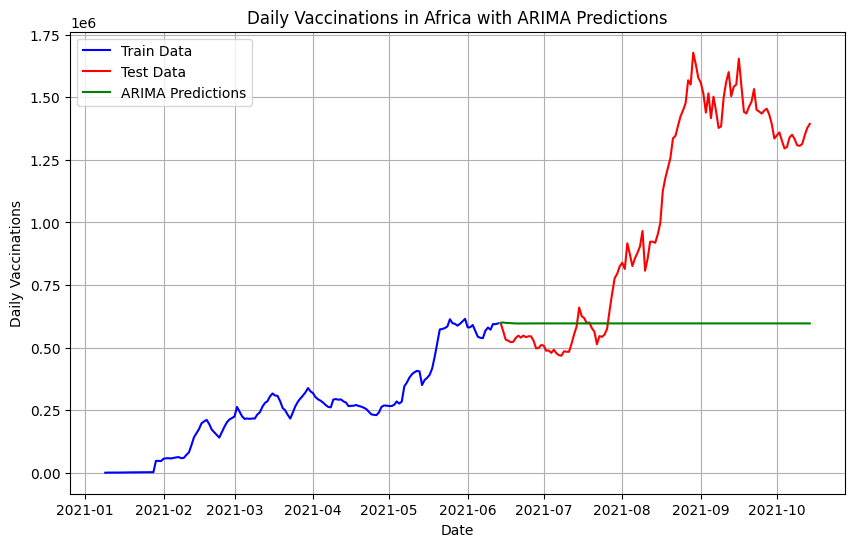

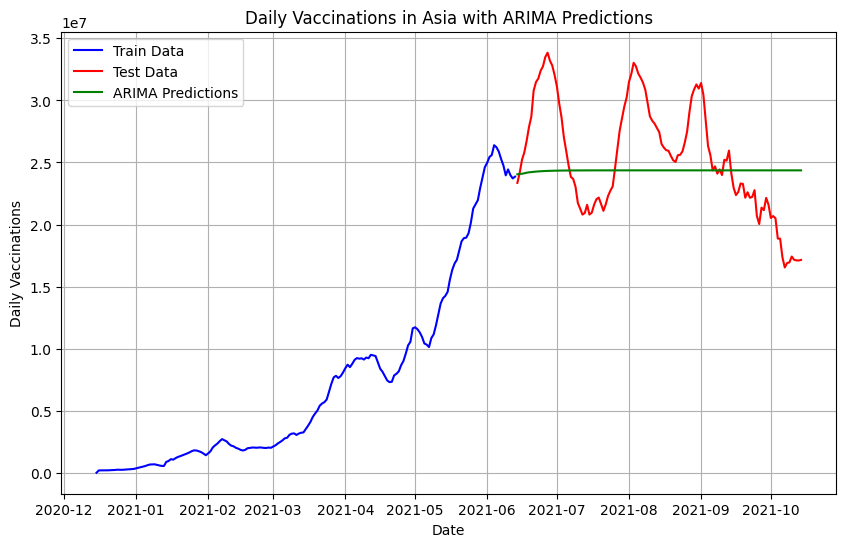

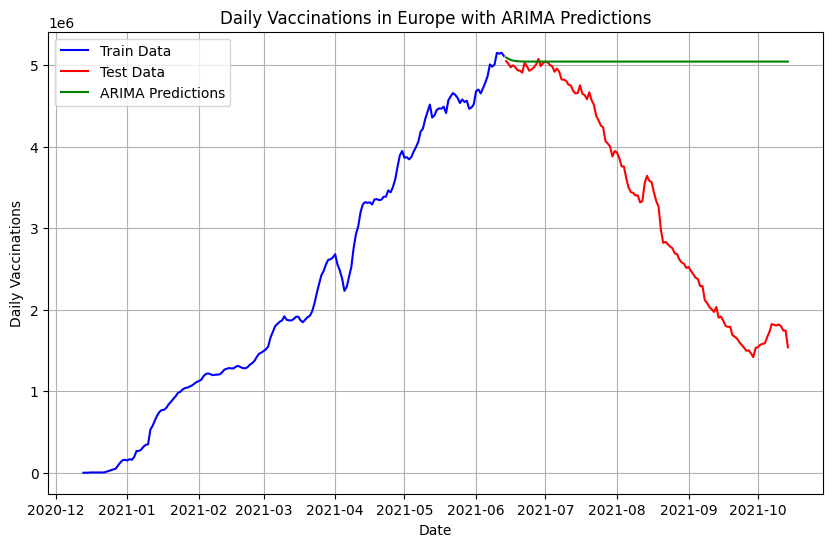

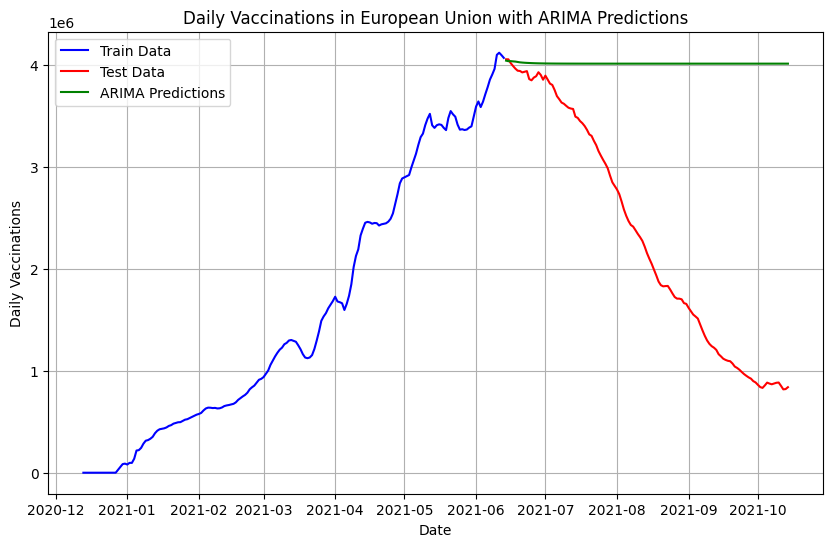

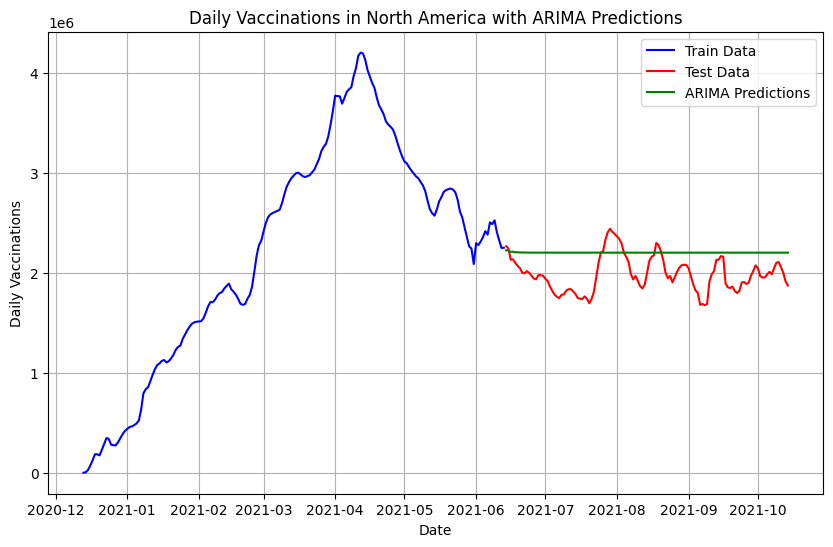

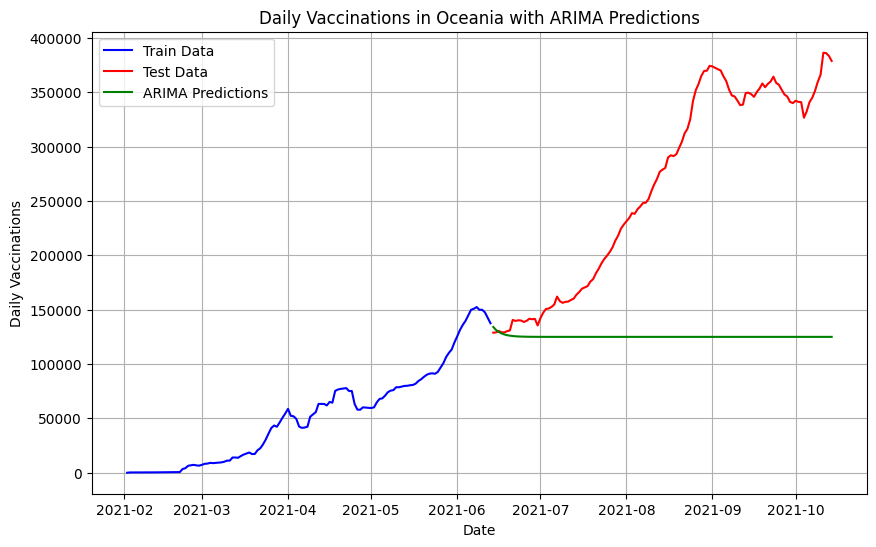

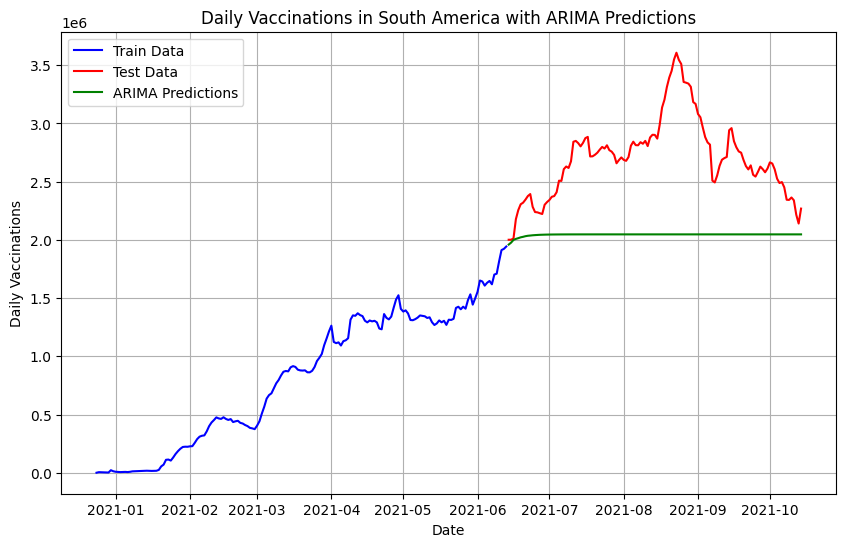

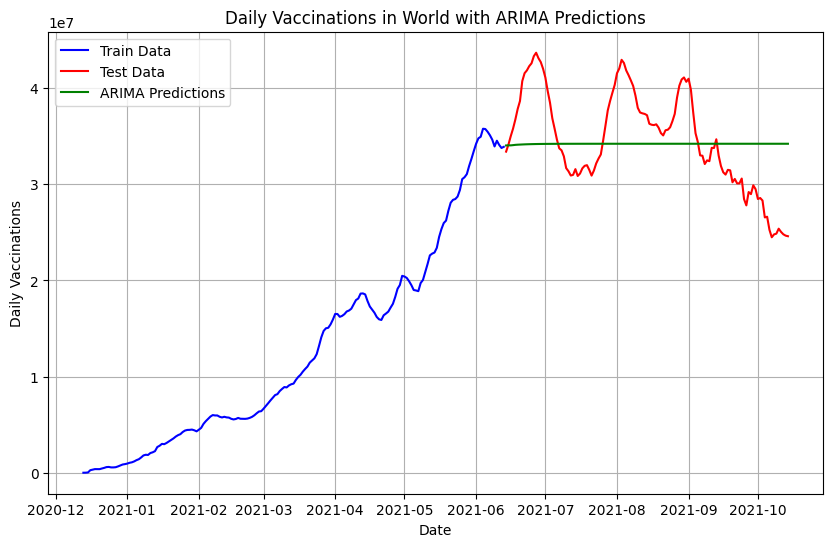


ARIMA RAE:
                             Value
ARIMA_Africa_RAE          1.188327
ARIMA_Asia_RAE            1.013650
ARIMA_Europe_RAE          1.475072
ARIMA_European Union_RAE  1.645809
ARIMA_North America_RAE   1.757336
ARIMA_Oceania_RAE         1.674832
ARIMA_South America_RAE   2.585018
ARIMA_World_RAE           1.004312

ARIMA MSLE:
                              Value
ARIMA_Africa_MSLE          0.396145
ARIMA_Asia_MSLE            0.033828
ARIMA_Europe_MSLE          0.443042
ARIMA_European Union_MSLE  0.775860
ARIMA_North America_MSLE   0.018952
ARIMA_Oceania_MSLE         0.604982
ARIMA_South America_MSLE   0.088706
ARIMA_World_MSLE           0.022886

ARIMA MASE:
                              Value
ARIMA_Africa_MASE          4.107057
ARIMA_Asia_MASE            1.126965
ARIMA_Europe_MASE          6.887811
ARIMA_European Union_MASE  8.812520
ARIMA_North America_MASE   1.239392
ARIMA_Oceania_MASE         6.732624
ARIMA_South America_MASE   3.121096
ARIMA_World_MASE           1.254222

In [ ]:
#train and  test for ARIMA model for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output


arima_results = {}
arima_predictions_dfs = {}

for continent in df_continents['location'].unique():
    train_data = train_dfs[continent]
    test_data = test_dfs[continent]

    # Prepare the data for ARIMA
    train_data_arima = train_data[['date', 'daily_vaccinations']].set_index('date')
    test_data_arima = test_data[['date', 'daily_vaccinations']].set_index('date')

    # Train the ARIMA model
    try:
        model = ARIMA(train_data_arima['daily_vaccinations'], order=(5, 1, 0))  # Example order, adjust as needed
        model_fit = model.fit()

        # Make predictions on the test data
        predictions = model_fit.predict(start=len(train_data_arima), end=len(train_data_arima) + len(test_data_arima) - 1)

        # Evaluate the model
        mae = mean_absolute_error(test_data_arima['daily_vaccinations'], predictions)
        mse = mean_squared_error(test_data_arima['daily_vaccinations'], predictions)
        rmse = np.sqrt(mse)
        rae = relative_absolute_error(test_data_arima['daily_vaccinations'], predictions)
        msle = mean_squared_log_error(test_data_arima['daily_vaccinations'], predictions)
        mase = mean_absolute_scaled_error(test_data_arima['daily_vaccinations'], predictions, seasonality=7)

        # Store the results
        arima_results[f'ARIMA_{continent}_RAE'] = rae
        arima_results[f'ARIMA_{continent}_MSLE'] = msle
        arima_results[f'ARIMA_{continent}_MASE'] = mase
        arima_predictions_dfs[f'ARIMA_{continent}_predictions'] = pd.DataFrame({'date': test_data_arima.index, 'daily_vaccinations': test_data_arima['daily_vaccinations'], 'predictions': predictions})

        # Plot the train, test, and predictions
        plt.figure(figsize=(10, 6))

        plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')
        plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')
        plt.plot(test_data['date'], predictions, color='green', label='ARIMA Predictions')

        plt.title(f'Daily Vaccinations in {continent} with ARIMA Predictions')
        plt.xlabel('Date')
        plt.ylabel('Daily Vaccinations')
        plt.grid(True)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error training ARIMA model for {continent}: {e}")


# Create DataFrames for RAE, MSLE, and MASE
arima_rae_df = pd.DataFrame.from_dict(arima_results, orient='index', columns=['Value']).sort_index()
arima_msle_df = pd.DataFrame.from_dict(arima_results, orient='index', columns=['Value']).sort_index()
arima_mase_df = pd.DataFrame.from_dict(arima_results, orient='index', columns=['Value']).sort_index()

# Filter the DataFrames to include only the relevant metrics
arima_rae_df = arima_rae_df[arima_rae_df.index.str.contains('RAE')]
arima_msle_df = arima_msle_df[arima_msle_df.index.str.contains('MSLE')]
arima_mase_df = arima_mase_df[arima_mase_df.index.str.contains('MASE')]

# Show the results
print("\nARIMA RAE:")
print(arima_rae_df)
print("\nARIMA MSLE:")
print(arima_msle_df)
print("\nARIMA MASE:")
print(arima_mase_df)




INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/k79uake9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/tcf_q98r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4404', 'data', 'file=/tmp/tmp2dywhhb3/k79uake9.json', 'init=/tmp/tmp2dywhhb3/tcf_q98r.json', 'output', 'file=/tmp/tmp2dywhhb3/prophet_modelw9yy992l/prophet_model-20241202035617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for Africa


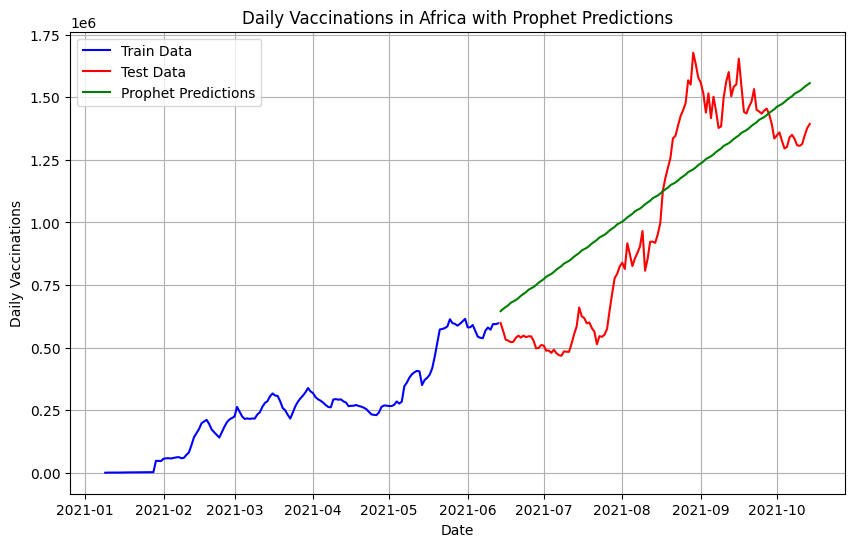

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/u7dzw1_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/t6qps136.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89826', 'data', 'file=/tmp/tmp2dywhhb3/u7dzw1_o.json', 'init=/tmp/tmp2dywhhb3/t6qps136.json', 'output', 'file=/tmp/tmp2dywhhb3/prophet_modelgd_ip_ox/prophet_model-20241202035618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for Asia


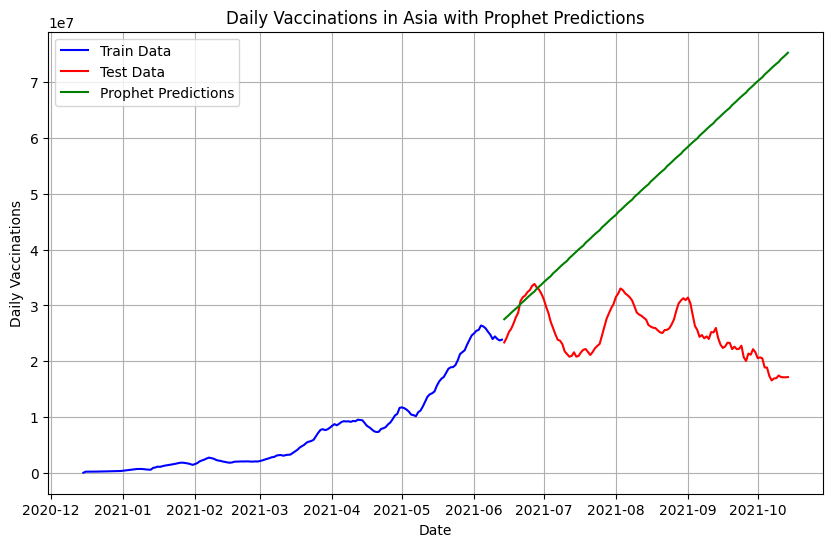

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/xp9w10l5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/ces_i8ox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92203', 'data', 'file=/tmp/tmp2dywhhb3/xp9w10l5.json', 'init=/tmp/tmp2dywhhb3/ces_i8ox.json', 'output', 'file=/tmp/tmp2dywhhb3/prophet_model6399_pd5/prophet_model-20241202035618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for Europe


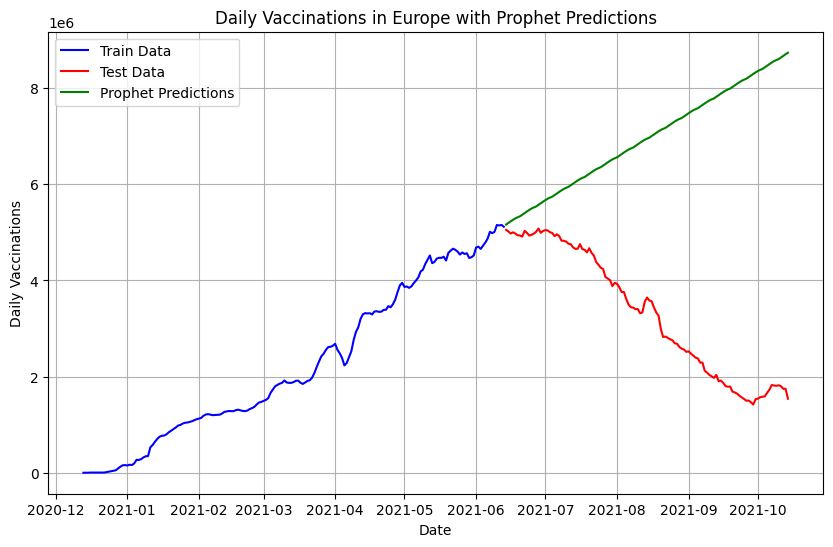

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/o137nkyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/wyqrmf0w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67778', 'data', 'file=/tmp/tmp2dywhhb3/o137nkyr.json', 'init=/tmp/tmp2dywhhb3/wyqrmf0w.json', 'output', 'file=/tmp/tmp2dywhhb3/prophet_modelem0zc4gz/prophet_model-20241202035619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for European Union


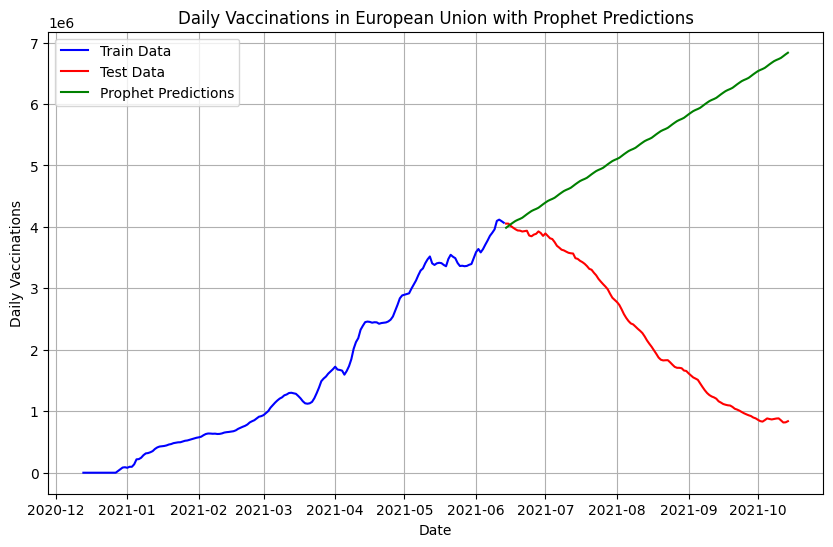

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/kgchp7pg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/dkmdwf3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54506', 'data', 'file=/tmp/tmp2dywhhb3/kgchp7pg.json', 'init=/tmp/tmp2dywhhb3/dkmdwf3r.json', 'output', 'file=/tmp/tmp2dywhhb3/prophet_model2aqwaqg5/prophet_model-20241202035619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for North America
Skipping MSLE calculation for North America due to negative values.


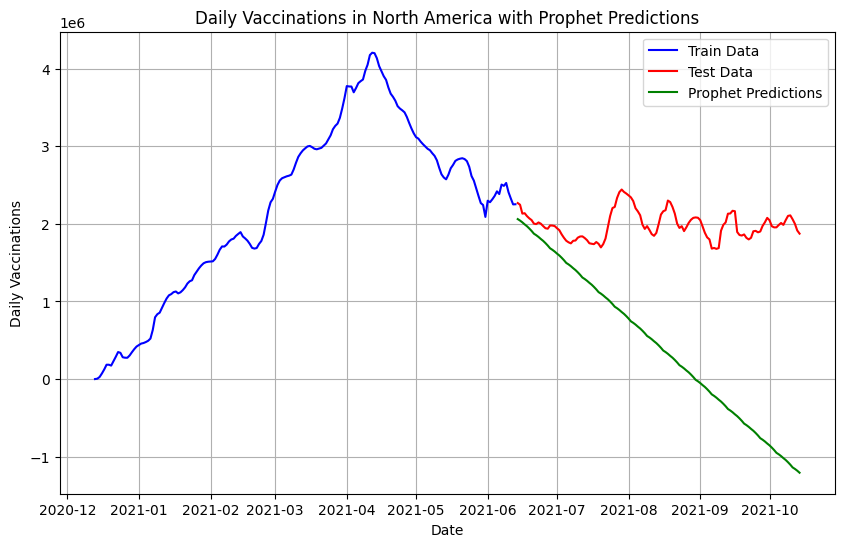

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/sr4ft691.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/gy8g_2e6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25927', 'data', 'file=/tmp/tmp2dywhhb3/sr4ft691.json', 'init=/tmp/tmp2dywhhb3/gy8g_2e6.json', 'output', 'file=/tmp/tmp2dywhhb3/prophet_modelhrpyi08m/prophet_model-20241202035620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for Oceania


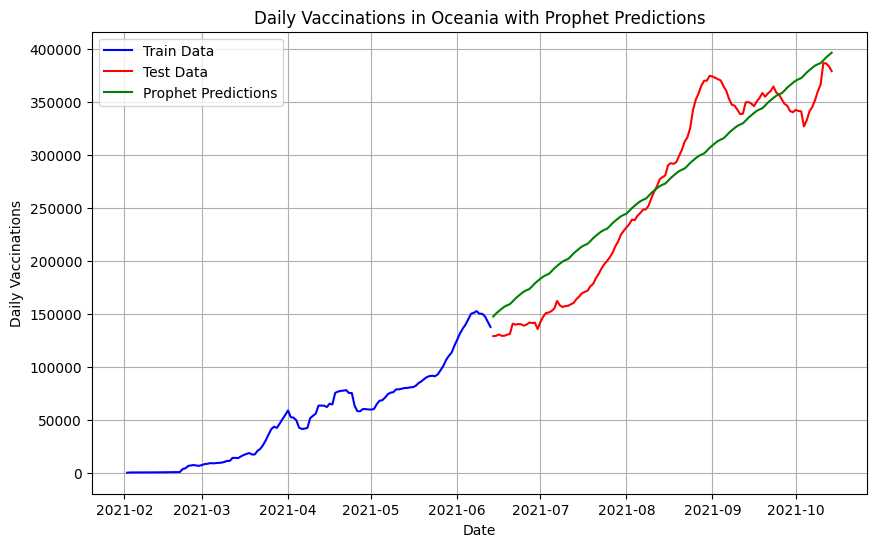

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/c5edtqvk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/mq49bndz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74762', 'data', 'file=/tmp/tmp2dywhhb3/c5edtqvk.json', 'init=/tmp/tmp2dywhhb3/mq49bndz.json', 'output', 'file=/tmp/tmp2dywhhb3/prophet_modelnotvmfs0/prophet_model-20241202035620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for South America


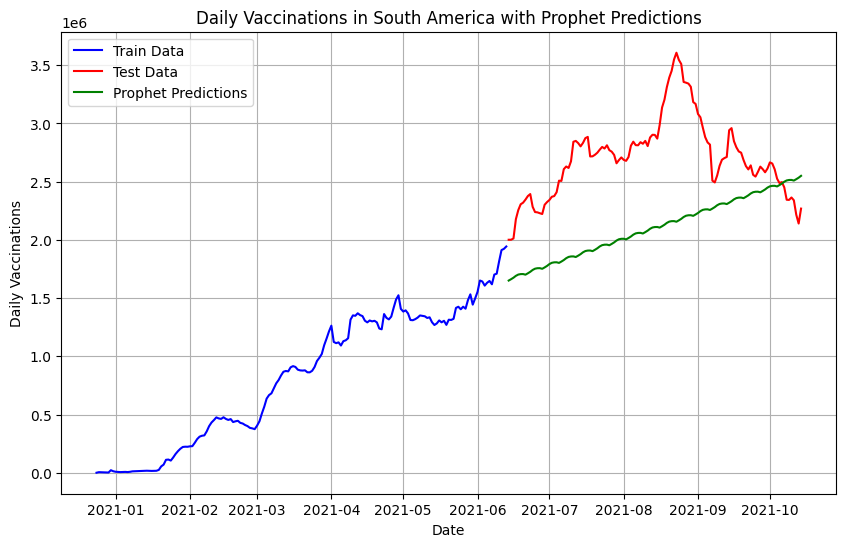

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/kuu7lax0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2dywhhb3/z0wwaz8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83095', 'data', 'file=/tmp/tmp2dywhhb3/kuu7lax0.json', 'init=/tmp/tmp2dywhhb3/z0wwaz8y.json', 'output', 'file=/tmp/tmp2dywhhb3/prophet_modelxojidp4q/prophet_model-20241202035621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:56:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:56:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training and testing Prophet for World


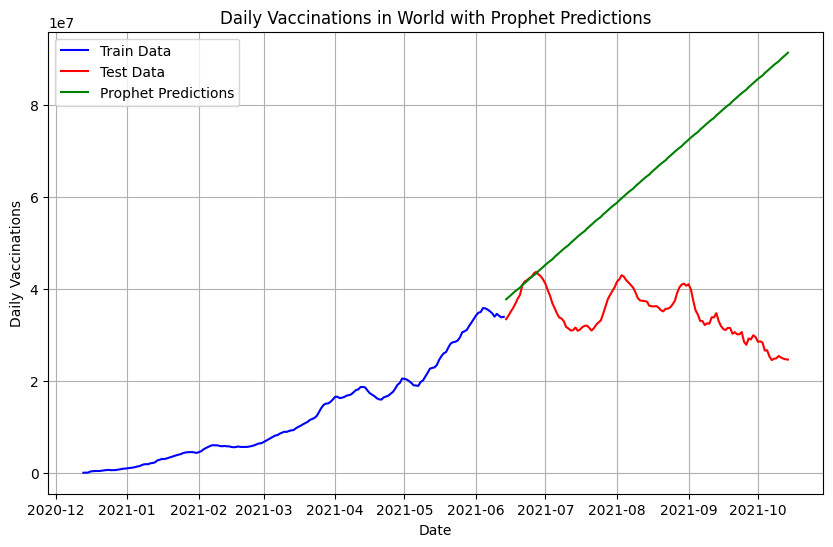

Prophet RAE DataFrame:
                                  RAE
Prophet_Africa_RAE           0.532640
Prophet_Asia_RAE             6.976264
Prophet_Europe_RAE           3.095716
Prophet_European Union_RAE   3.007323
Prophet_North America_RAE   11.273120
Prophet_Oceania_RAE          0.332396
Prophet_South America_RAE    2.459936
Prophet_World_RAE            7.017795

Prophet MSLE DataFrame:
                                 MSLE
Prophet_Africa_MSLE          0.079931
Prophet_Asia_MSLE            0.634055
Prophet_Europe_MSLE          0.999488
Prophet_European Union_MSLE  1.444658
Prophet_North America_MSLE        NaN
Prophet_Oceania_MSLE         0.020494
Prophet_South America_MSLE   0.084850
Prophet_World_MSLE           0.493635

Prophet MASE DataFrame:
                                   MASE
Prophet_Africa_MASE           18.820811
Prophet_Asia_MASE            111.258826
Prophet_Europe_MASE           82.645332
Prophet_European Union_MASE   97.290275
Prophet_North America_MASE    32.895114
Pro

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_log_error

# Custom Metric Functions
def relative_absolute_error(y_true, y_pred):
    numerator = sum(abs(y_true - y_pred))
    denominator = sum(abs(y_true - y_true.mean()))
    return numerator / denominator

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    n = len(y_train)
    mae = sum(abs(y_true - y_pred)) / len(y_true)
    naive_mae = sum(abs(y_train[1:] - y_train[:-1])) / (n - 1)
    return mae / naive_mae

# Create dictionaries to store metrics and predictions
prophet_continent_rae = {}
prophet_continent_msle = {}
prophet_continent_mase = {}
prophet_continent_predictions = {}

# Loop through each continent
for continent in df_continents['location'].unique():
    print(f"Training and testing Prophet for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for Prophet
    train_prophet = train_data[['date', 'daily_vaccinations']].rename(columns={'date': 'ds', 'daily_vaccinations': 'y'})
    test_prophet = test_data[['date', 'daily_vaccinations']].rename(columns={'date': 'ds', 'daily_vaccinations': 'y'})

    # Fit the Prophet model
    model = Prophet()
    model.fit(train_prophet)

    # Create a future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_prophet), freq='D')
    forecast = model.predict(future)

    # Extract predictions corresponding to test dates
    predictions = forecast.set_index('ds').loc[test_prophet['ds'], 'yhat']

    # Ensure no negative values in the data for MSLE
    if (test_prophet['y'] < 0).any() or (predictions < 0).any():
        print(f"Skipping MSLE calculation for {continent} due to negative values.")
        msle = None
    else:
        msle = mean_squared_log_error(test_prophet['y'].values, predictions.values)

    # Calculate metrics
    rae = relative_absolute_error(test_prophet['y'].values, predictions.values)
    mase = mean_absolute_scaled_error(test_prophet['y'].values, predictions.values, train_prophet['y'].values)

    # Store metrics and predictions
    prophet_continent_rae[f'Prophet_{continent}_RAE'] = rae
    prophet_continent_msle[f'Prophet_{continent}_MSLE'] = msle
    prophet_continent_mase[f'Prophet_{continent}_MASE'] = mase
    prophet_continent_predictions[f'Prophet_{continent}_predictions'] = predictions.values

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_data['date'], train_data['daily_vaccinations'], label='Train Data', color='blue')
    plt.plot(test_data['date'], test_data['daily_vaccinations'], label='Test Data', color='red')
    plt.plot(test_data['date'], predictions, label='Prophet Predictions', color='green')
    plt.title(f'Daily Vaccinations in {continent} with Prophet Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create DataFrames for metrics
prophet_rae_df = pd.DataFrame.from_dict(prophet_continent_rae, orient='index', columns=['RAE'])
prophet_msle_df = pd.DataFrame.from_dict(prophet_continent_msle, orient='index', columns=['MSLE'])
prophet_mase_df = pd.DataFrame.from_dict(prophet_continent_mase, orient='index', columns=['MASE'])

# Align predictions into a DataFrame with NaN padding for unequal lengths
max_length = max(len(pred) for pred in prophet_continent_predictions.values())
for key in prophet_continent_predictions:
    prophet_continent_predictions[key] = list(prophet_continent_predictions[key]) + [float('nan')] * (
        max_length - len(prophet_continent_predictions[key])
    )

# Create DataFrame for predictions
prophet_predictions_df = pd.DataFrame.from_dict(prophet_continent_predictions)

# Print DataFrames
print("Prophet RAE DataFrame:")
print(prophet_rae_df)

print("\nProphet MSLE DataFrame:")
print(prophet_msle_df)

print("\nProphet MASE DataFrame:")
print(prophet_mase_df)

print("\nProphet Predictions DataFrame:")
print(prophet_predictions_df)


Training and testing LSTM for Africa
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


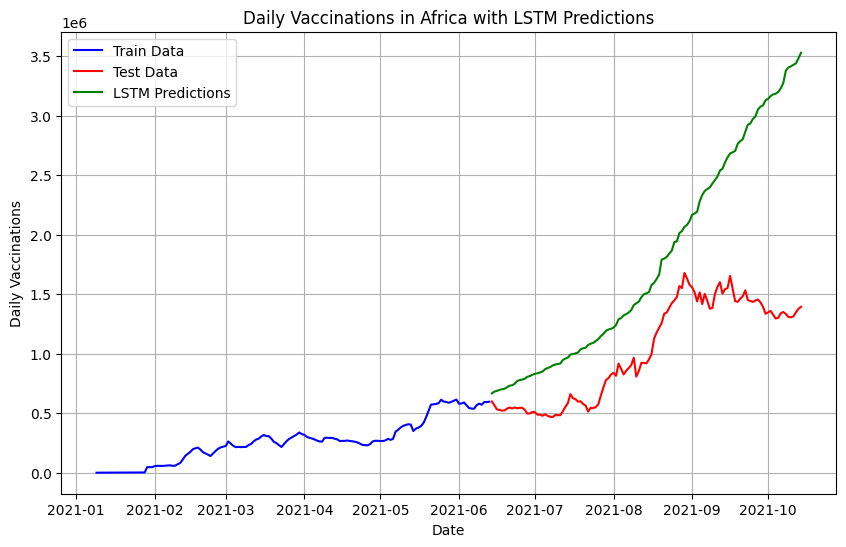

Training and testing LSTM for Asia
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


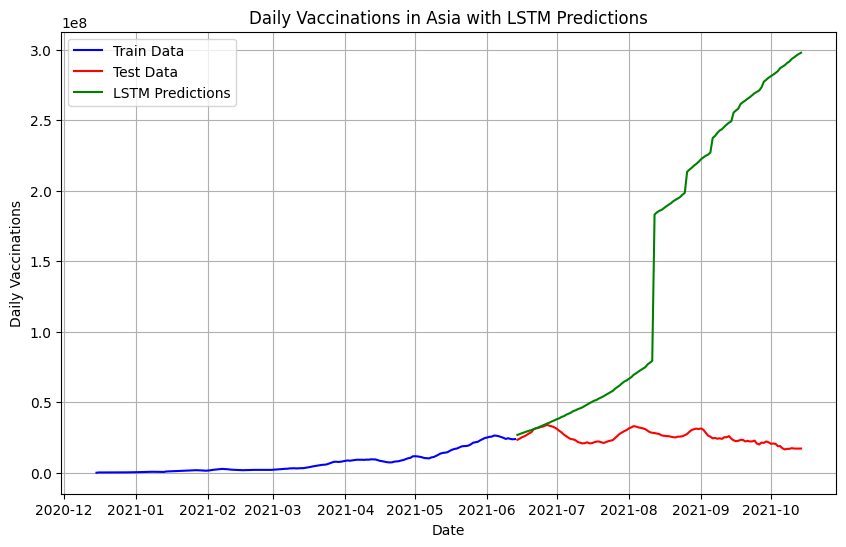

Training and testing LSTM for Europe
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


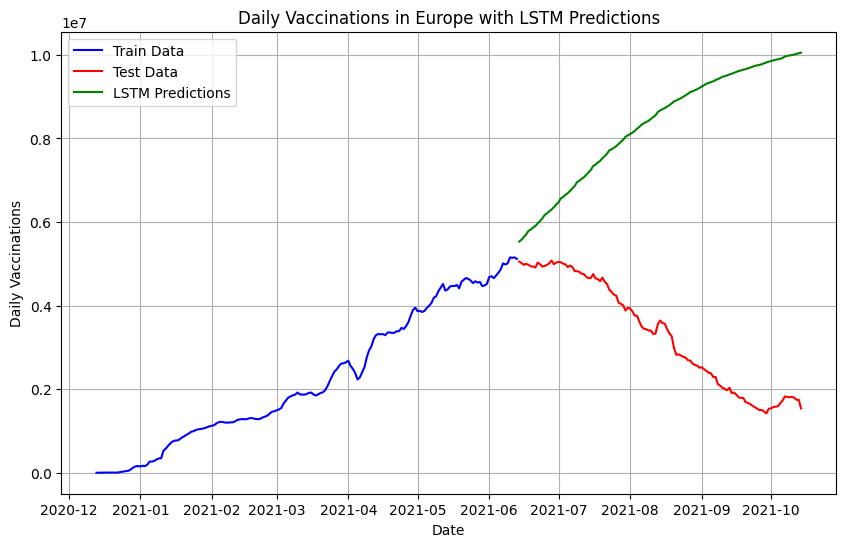

Training and testing LSTM for European Union
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


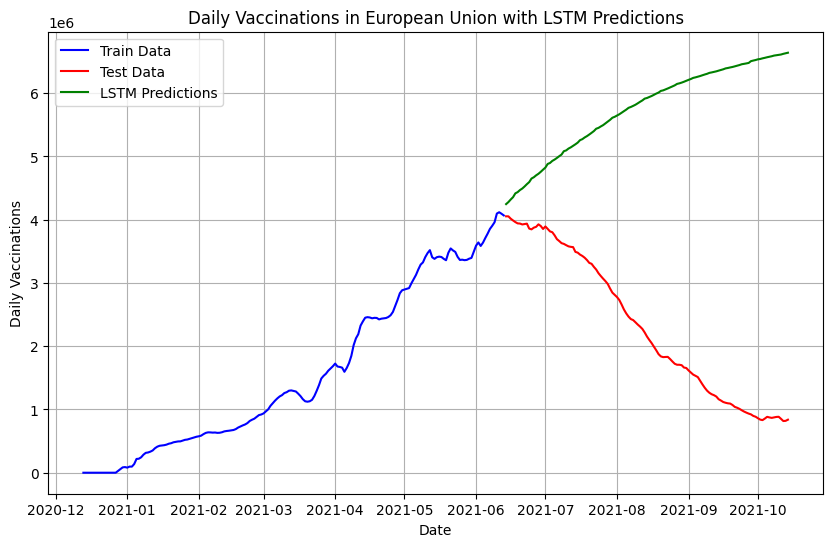

Training and testing LSTM for North America
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


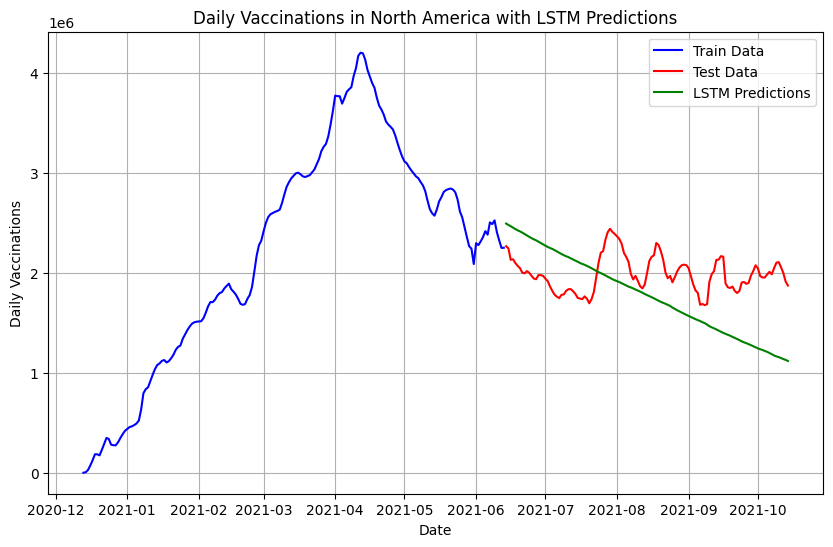

Training and testing LSTM for Oceania
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


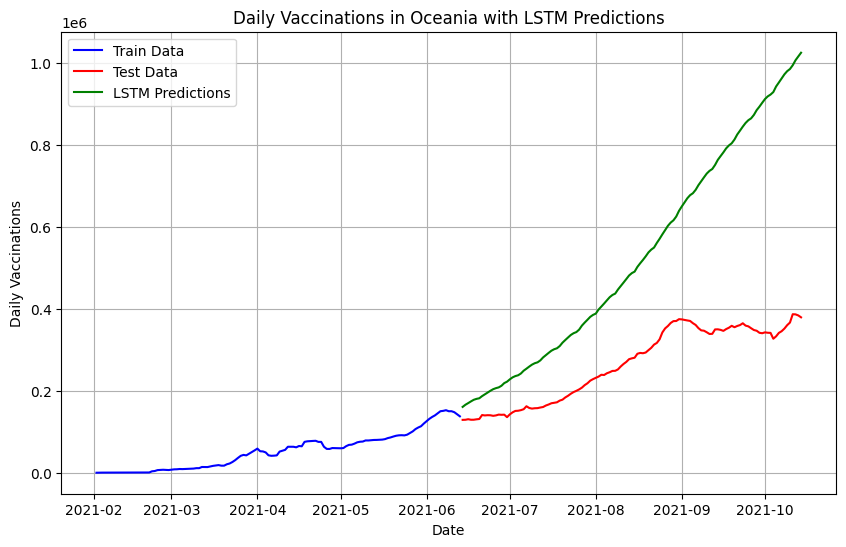

Training and testing LSTM for South America
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


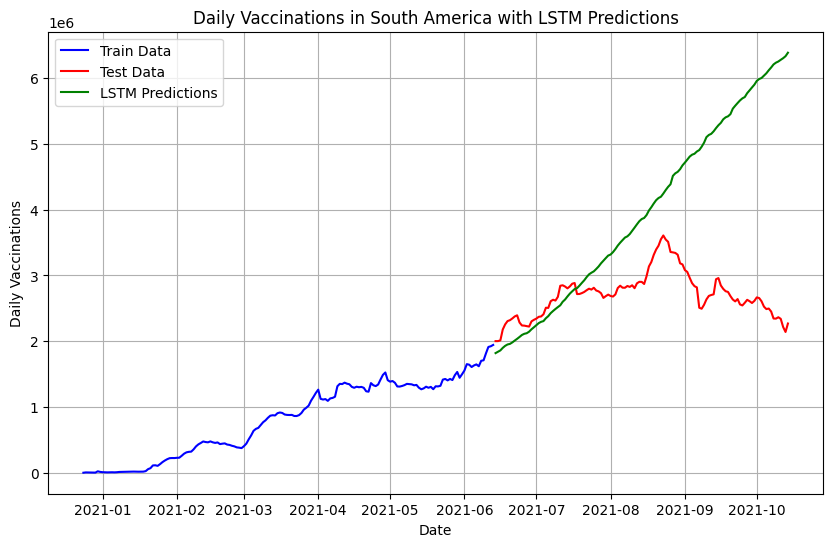

Training and testing LSTM for World
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


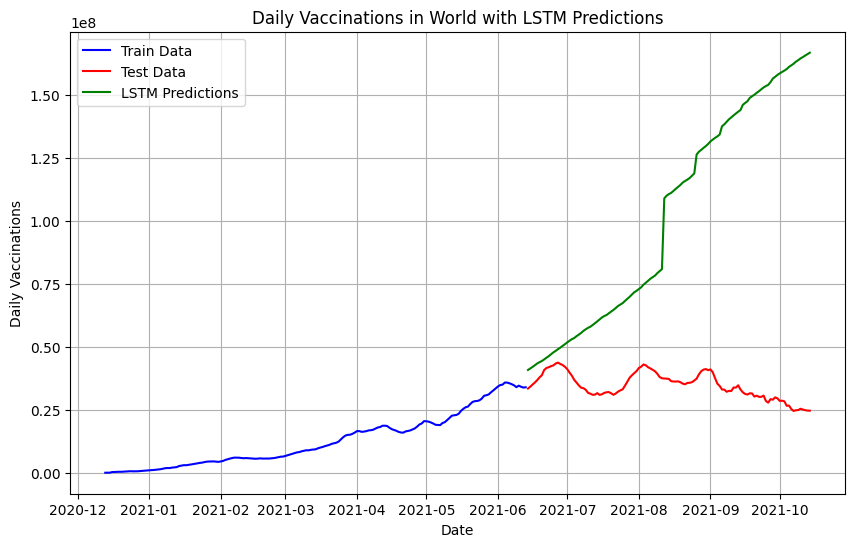

LSTM RAE DataFrame:
                               RAE
LSTM_Africa_RAE           1.961160
LSTM_Asia_RAE            33.434166
LSTM_Europe_RAE           4.268274
LSTM_European Union_RAE   3.333720
LSTM_North America_RAE    3.119349
LSTM_Oceania_RAE          3.202918
LSTM_South America_RAE    5.336273
LSTM_World_RAE           15.792259

LSTM MSLE DataFrame:
                              MSLE
LSTM_Africa_MSLE          0.315948
LSTM_Asia_MSLE            3.097773
LSTM_Europe_MSLE          1.337179
LSTM_European Union_MSLE  1.527962
LSTM_North America_MSLE   0.077183
LSTM_Oceania_MSLE         0.428751
LSTM_South America_MSLE   0.232059
LSTM_World_MSLE           1.291369

LSTM MASE DataFrame:
                                MASE
LSTM_Africa_MASE           69.297497
LSTM_Asia_MASE            533.214615
LSTM_Europe_MASE          113.948714
LSTM_European Union_MASE  107.849568
LSTM_North America_MASE     9.102303
LSTM_Oceania_MASE         135.482762
LSTM_South America_MASE    54.295603
LSTM_World

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error

# Define metric functions
def relative_absolute_error(y_true, y_pred):
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    return numerator / denominator

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    n = len(y_train)
    mae = np.mean(np.abs(y_true - y_pred))
    naive_mae = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    return mae / naive_mae

# Dictionaries to store metrics and predictions
lstm_continent_rae = {}
lstm_continent_msle = {}
lstm_continent_mase = {}
lstm_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing LSTM for {continent}")

    # Prepare train and test data
    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    train_X = scaler_X.fit_transform(train_X)
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_X = scaler_X.transform(test_X)
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    # Reshape for LSTM
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Build the LSTM model
    model = Sequential()
    model.add(layers.LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(train_X, train_y, epochs=50, verbose=0)

    # Make predictions
    predictions = model.predict(test_X)

    # Inverse transform predictions and test_y
    predictions = scaler_y.inverse_transform(predictions).flatten()
    test_y = scaler_y.inverse_transform(test_y).flatten()

    # Clip negative values for MSLE
    predictions = np.clip(predictions, 0, None)
    test_y = np.clip(test_y, 0, None)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, scaler_y.inverse_transform(train_y).flatten())

    # Store metrics and predictions
    lstm_continent_rae[f'LSTM_{continent}_RAE'] = rae
    lstm_continent_msle[f'LSTM_{continent}_MSLE'] = msle
    lstm_continent_mase[f'LSTM_{continent}_MASE'] = mase
    lstm_continent_predictions[f'LSTM_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_data['date'], train_data['daily_vaccinations'], label='Train Data', color='blue')
    plt.plot(test_data['date'], test_data['daily_vaccinations'], label='Test Data', color='red')
    plt.plot(test_data['date'], predictions, label='LSTM Predictions', color='green')
    plt.title(f'Daily Vaccinations in {continent} with LSTM Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create DataFrames for metrics
lstm_rae_df = pd.DataFrame.from_dict(lstm_continent_rae, orient='index', columns=['RAE'])
lstm_msle_df = pd.DataFrame.from_dict(lstm_continent_msle, orient='index', columns=['MSLE'])
lstm_mase_df = pd.DataFrame.from_dict(lstm_continent_mase, orient='index', columns=['MASE'])

# Print DataFrames
print("LSTM RAE DataFrame:")
print(lstm_rae_df)

print("\nLSTM MSLE DataFrame:")
print(lstm_msle_df)

print("\nLSTM MASE DataFrame:")
print(lstm_mase_df)


Training and testing Exponential Smoothing for Africa


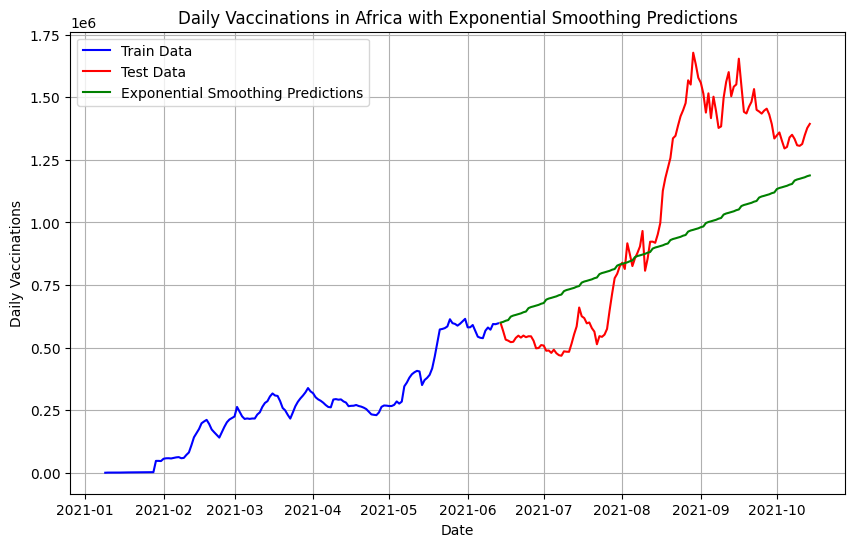

Training and testing Exponential Smoothing for Asia


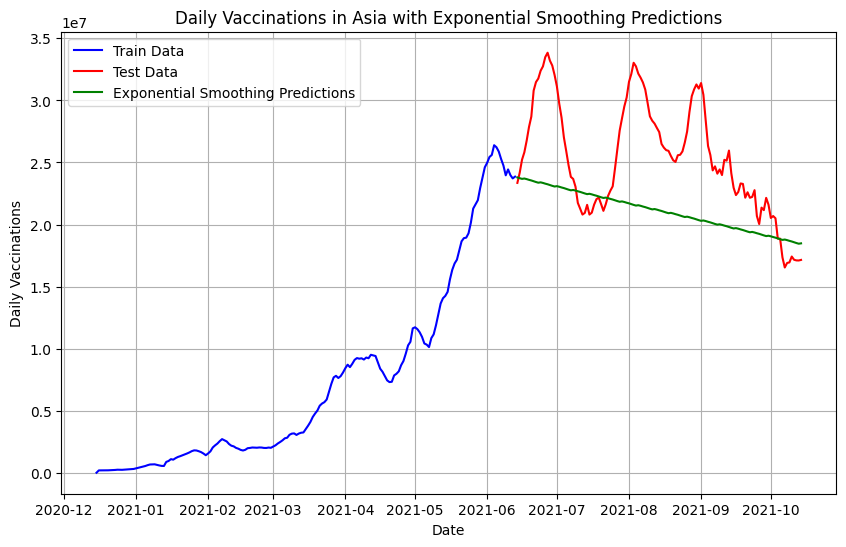

Training and testing Exponential Smoothing for Europe


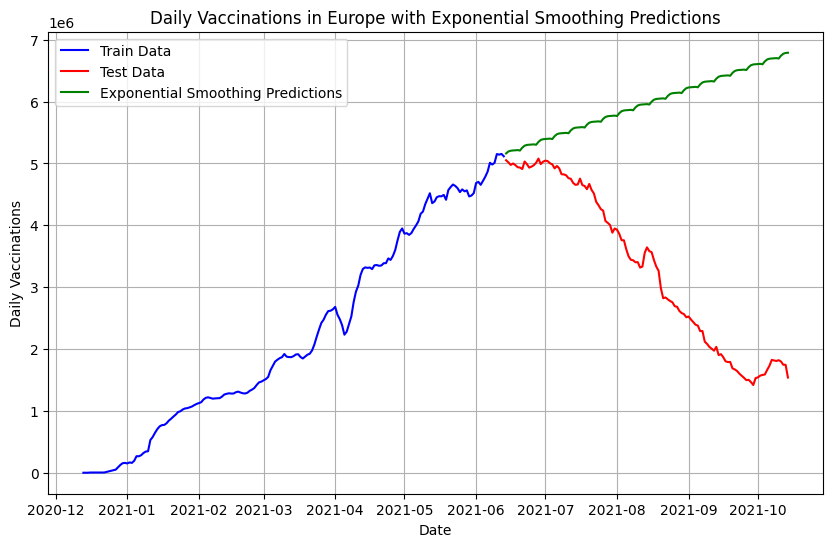

Training and testing Exponential Smoothing for European Union


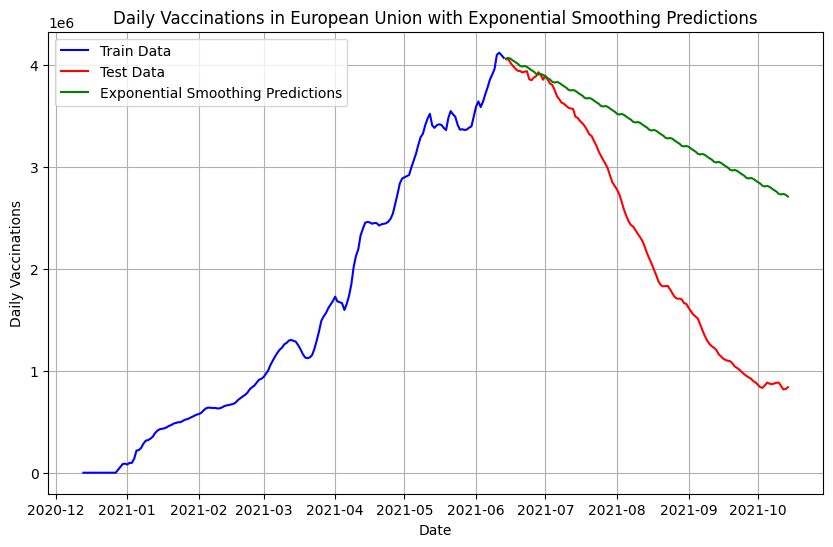

Training and testing Exponential Smoothing for North America


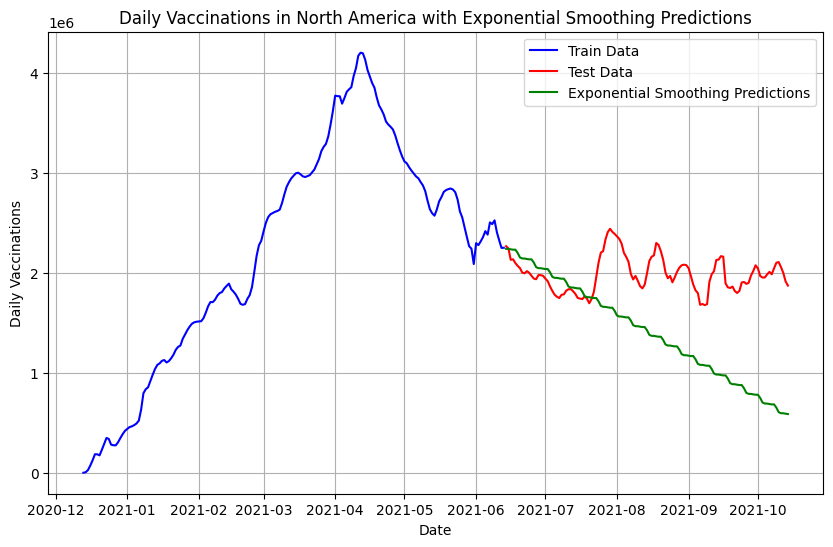

Training and testing Exponential Smoothing for Oceania
Error training Exponential Smoothing for Oceania: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
Training and testing Exponential Smoothing for South America


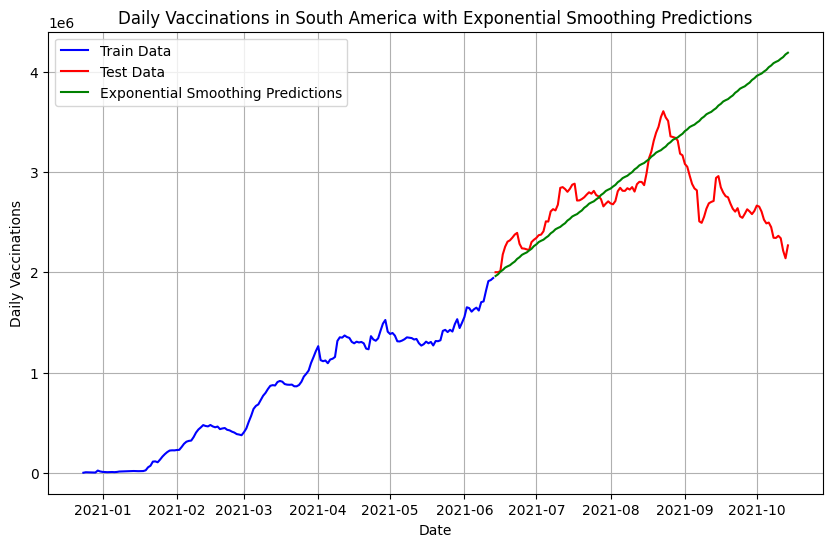

Training and testing Exponential Smoothing for World


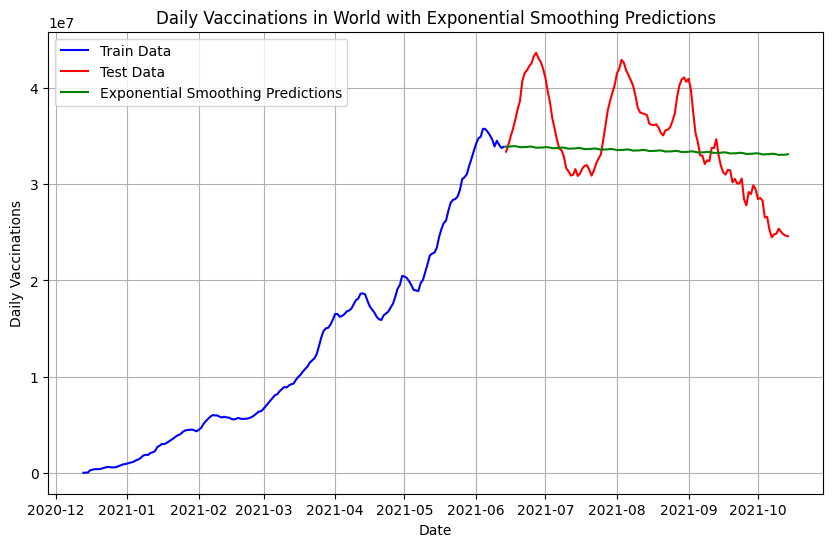

Exponential Smoothing RAE DataFrame:
                       RAE
ES_Africa_RAE          0.0
ES_Asia_RAE            0.0
ES_Europe_RAE          0.0
ES_European Union_RAE  0.0
ES_North America_RAE   0.0
ES_South America_RAE   0.0
ES_World_RAE           0.0

Exponential Smoothing MSLE DataFrame:
                            MSLE
ES_Africa_MSLE          0.082022
ES_Asia_MSLE            0.051926
ES_Europe_MSLE          0.710418
ES_European Union_MSLE  0.449322
ES_North America_MSLE   0.312880
ES_South America_MSLE   0.058448
ES_World_MSLE           0.021922

Exponential Smoothing MASE DataFrame:
                        MASE
ES_Africa_MASE           NaN
ES_Asia_MASE             NaN
ES_Europe_MASE           NaN
ES_European Union_MASE   NaN
ES_North America_MASE    NaN
ES_South America_MASE    NaN
ES_World_MASE            NaN

Exponential Smoothing Predictions DataFrame:
Empty DataFrame
Columns: [Predictions]
Index: []


In [ ]:
# train and  test for Exponential Smoothing for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es_continent_rae = {}
es_continent_msle = {}
es_continent_mase = {}
es_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing Exponential Smoothing for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for Exponential Smoothing
    train_target = train_data['daily_vaccinations']
    test_target = test_data['daily_vaccinations']

    # Fit the Exponential Smoothing model
    try:
        model = ExponentialSmoothing(train_target, trend='add', seasonal='add', seasonal_periods=7)  # You can adjust the parameters
        model_fit = model.fit()

        # Make predictions on the test data
        predictions = model_fit.predict(start=len(train_target), end=len(train_target) + len(test_target) - 1)

        # Calculate metrics
        rae = relative_absolute_error(test_target, predictions)
        msle = mean_squared_log_error(test_target, predictions)
        mase = mean_absolute_scaled_error(test_target, predictions, train_target)

        # Store the metrics
        es_continent_rae[f'ES_{continent}_RAE'] = rae
        es_continent_msle[f'ES_{continent}_MSLE'] = msle
        es_continent_mase[f'ES_{continent}_MASE'] = mase
        es_continent_predictions[f'ES_{continent}_predictions'] = predictions


        # Plot the results
        plt.figure(figsize=(10, 6))

        # Plot the train data in blue
        plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

        # Plot the test data in red
        plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

        # Plot the predictions in green
        plt.plot(test_data['date'], predictions, color='green', label='Exponential Smoothing Predictions')

        plt.title(f'Daily Vaccinations in {continent} with Exponential Smoothing Predictions')
        plt.xlabel('Date')
        plt.ylabel('Daily Vaccinations')
        plt.grid(True)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error training Exponential Smoothing for {continent}: {e}")
        # Handle the error appropriately (e.g., log it or skip the continent)


# Create DataFrames for RAE, MSLE, and MASE
es_rae_df = pd.DataFrame.from_dict(es_continent_rae, orient='index', columns=['RAE'])
es_msle_df = pd.DataFrame.from_dict(es_continent_msle, orient='index', columns=['MSLE'])
es_mase_df = pd.DataFrame.from_dict(es_continent_mase, orient='index', columns=['MASE'])


# Create DataFrame for predictions
es_predictions_df = pd.DataFrame.from_dict(es_continent_predictions, orient='index', columns=['Predictions'])


print("Exponential Smoothing RAE DataFrame:")
print(es_rae_df)

print("\nExponential Smoothing MSLE DataFrame:")
print(es_msle_df)

print("\nExponential Smoothing MASE DataFrame:")
print(es_mase_df)

print("\nExponential Smoothing Predictions DataFrame:")
print(es_predictions_df)


Training and testing XGBoost for Africa


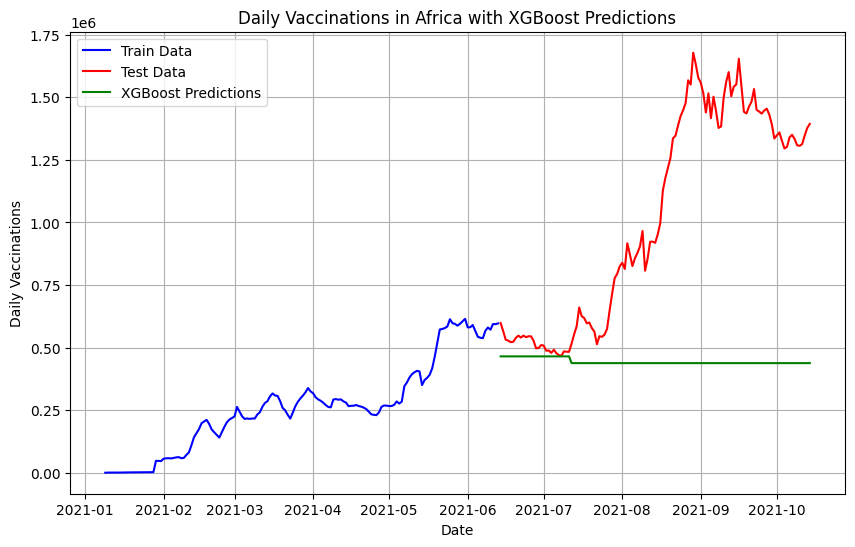

Training and testing XGBoost for Asia


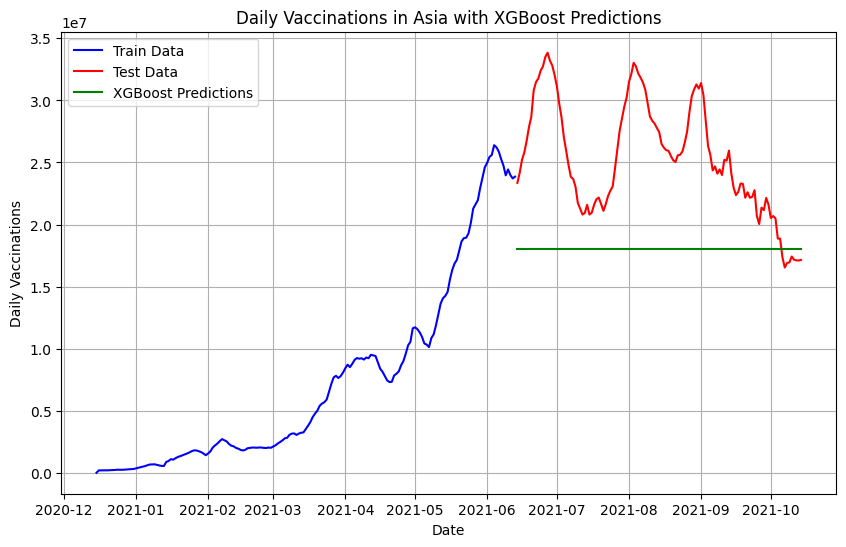

Training and testing XGBoost for Europe


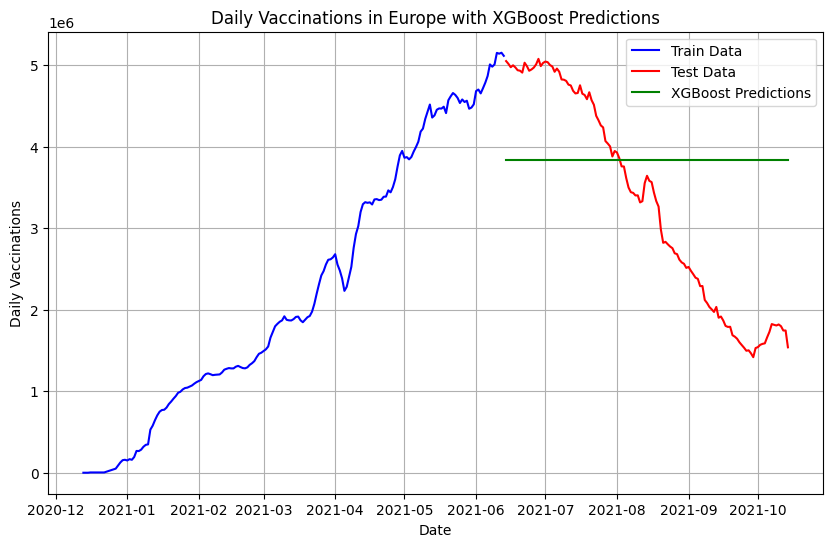

Training and testing XGBoost for European Union


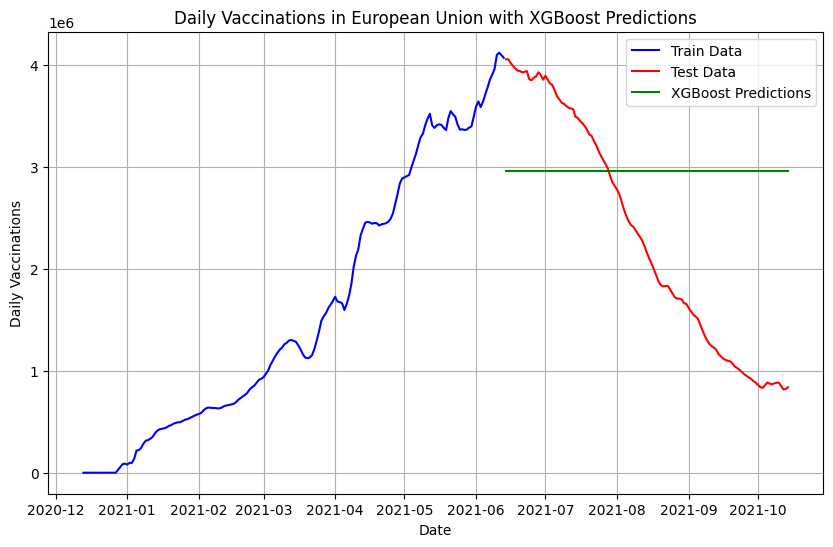

Training and testing XGBoost for North America


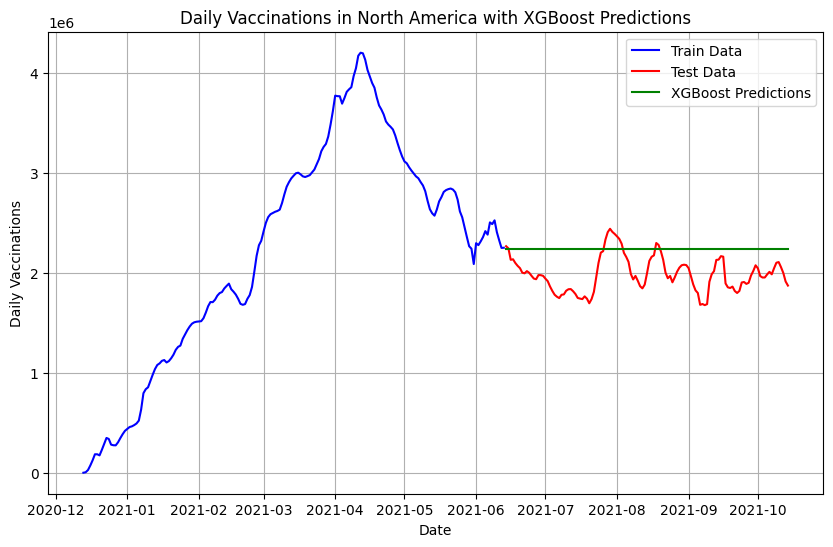

Training and testing XGBoost for Oceania


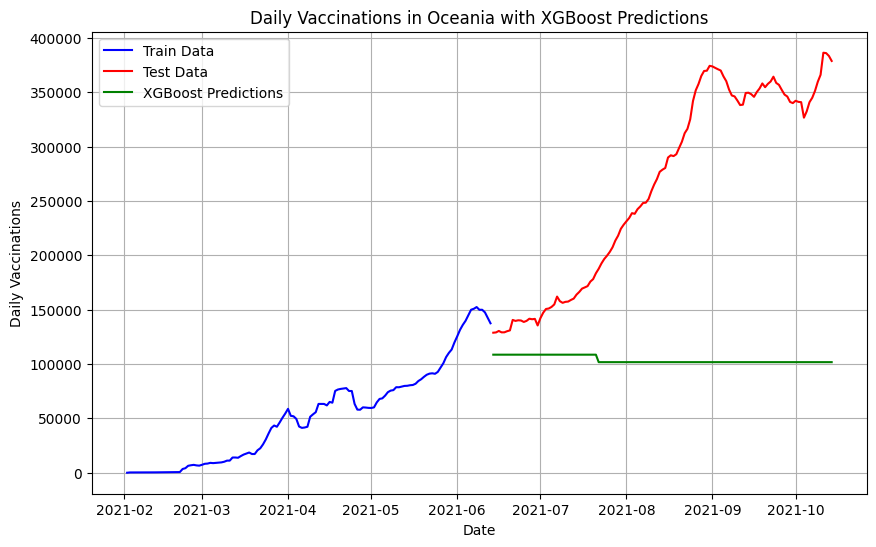

Training and testing XGBoost for South America


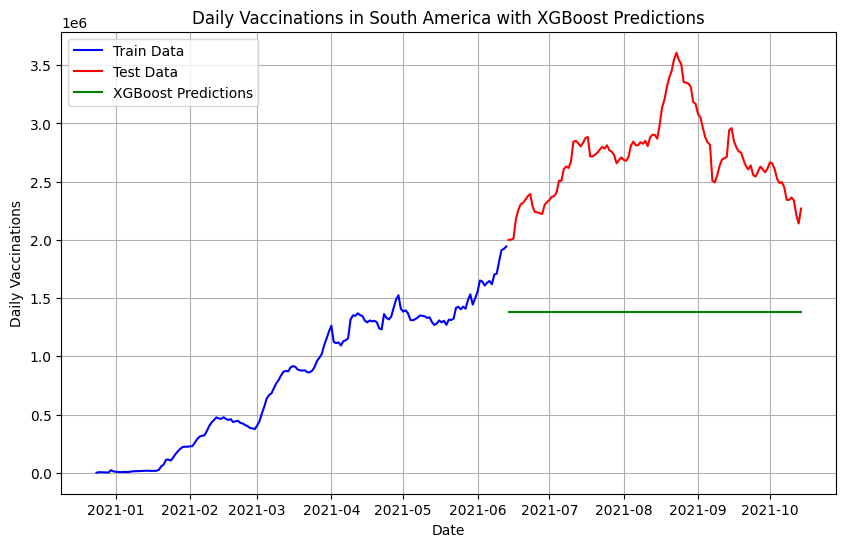

Training and testing XGBoost for World


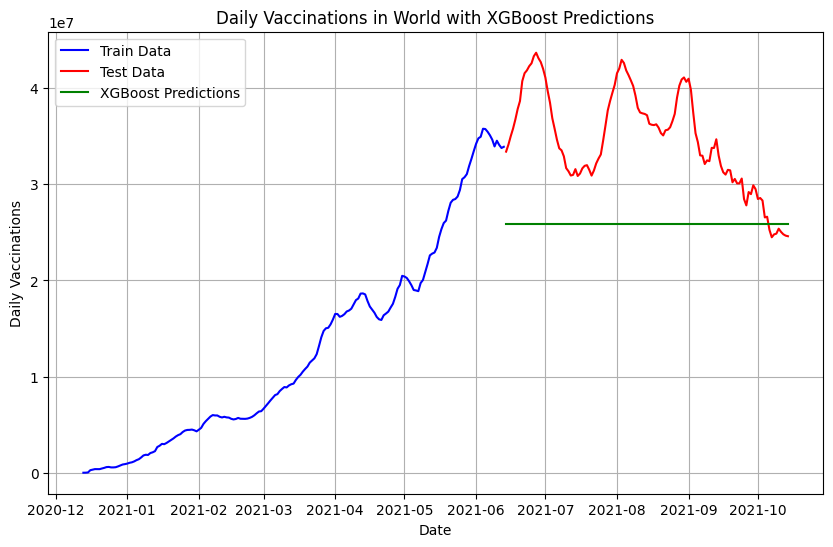

XGBoost RAE DataFrame:
                                 RAE
XGBoost_Africa_RAE          1.464056
XGBoost_Asia_RAE            1.990823
XGBoost_Europe_RAE          1.040876
XGBoost_European Union_RAE  1.108463
XGBoost_North America_RAE   1.983732
XGBoost_Oceania_RAE         1.931908
XGBoost_South America_RAE   5.168953
XGBoost_World_RAE           2.101189

XGBoost MSLE DataFrame:
                                 MSLE
XGBoost_Africa_MSLE          0.760158
XGBoost_Asia_MSLE            0.138447
XGBoost_Europe_MSLE          0.240308
XGBoost_European Union_MSLE  0.450624
XGBoost_North America_MSLE   0.023036
XGBoost_Oceania_MSLE         0.912977
XGBoost_South America_MSLE   0.453476
XGBoost_World_MSLE           0.102441

XGBoost MASE DataFrame:
                                  MASE
XGBoost_Africa_MASE          51.732329
XGBoost_Asia_MASE            31.750040
XGBoost_Europe_MASE          27.787917
XGBoost_European Union_MASE  35.860011
XGBoost_North America_MASE    5.788556
XGBoost_Oceania_MA

In [ ]:
#train and  test for XGBoost for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


xgboost_continent_rae = {}
xgboost_continent_msle = {}
xgboost_continent_mase = {}
xgboost_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing XGBoost for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for XGBoost
    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    # Create XGBoost model
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

    # Train the model
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, train_y)

    # Store the metrics
    xgboost_continent_rae[f'XGBoost_{continent}_RAE'] = rae
    xgboost_continent_msle[f'XGBoost_{continent}_MSLE'] = msle
    xgboost_continent_mase[f'XGBoost_{continent}_MASE'] = mase
    xgboost_continent_predictions[f'XGBoost_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='XGBoost Predictions')

    plt.title(f'Daily Vaccinations in {continent} with XGBoost Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
xgboost_rae_df = pd.DataFrame.from_dict(xgboost_continent_rae, orient='index', columns=['RAE'])
xgboost_msle_df = pd.DataFrame.from_dict(xgboost_continent_msle, orient='index', columns=['MSLE'])
xgboost_mase_df = pd.DataFrame.from_dict(xgboost_continent_mase, orient='index', columns=['MASE'])


print("XGBoost RAE DataFrame:")
print(xgboost_rae_df)

print("\nXGBoost MSLE DataFrame:")
print(xgboost_msle_df)

print("\nXGBoost MASE DataFrame:")
print(xgboost_mase_df)



Training and testing LightGBM for Africa


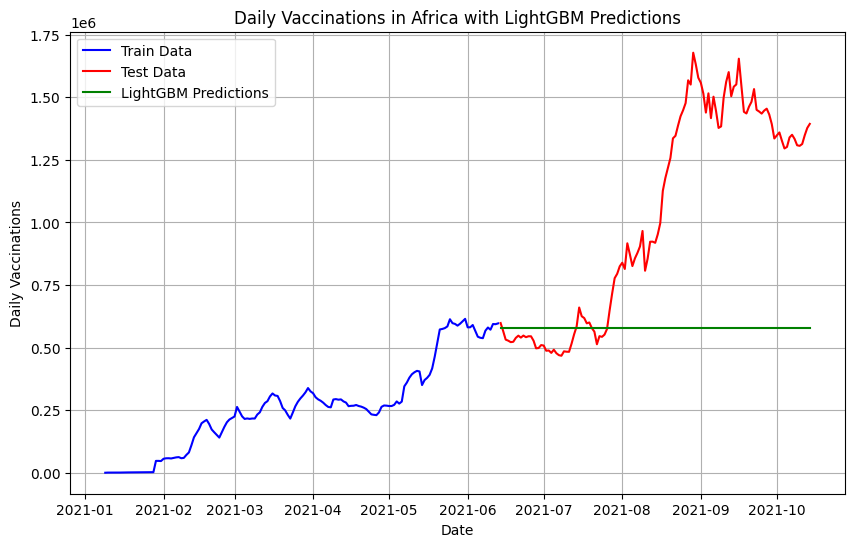

Training and testing LightGBM for Asia


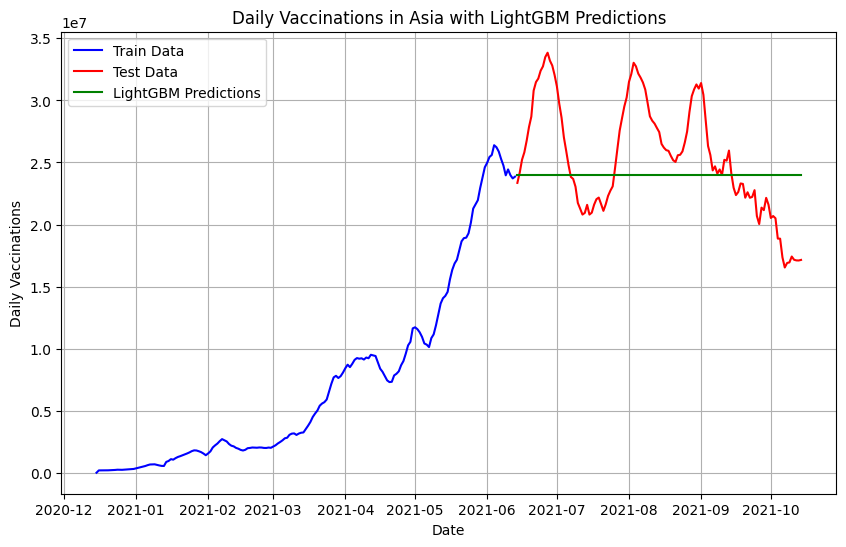

Training and testing LightGBM for Europe


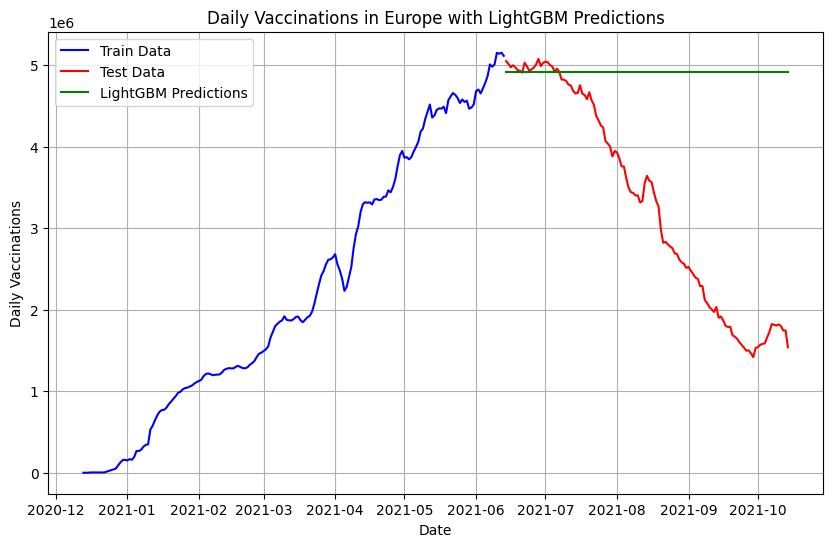

Training and testing LightGBM for European Union


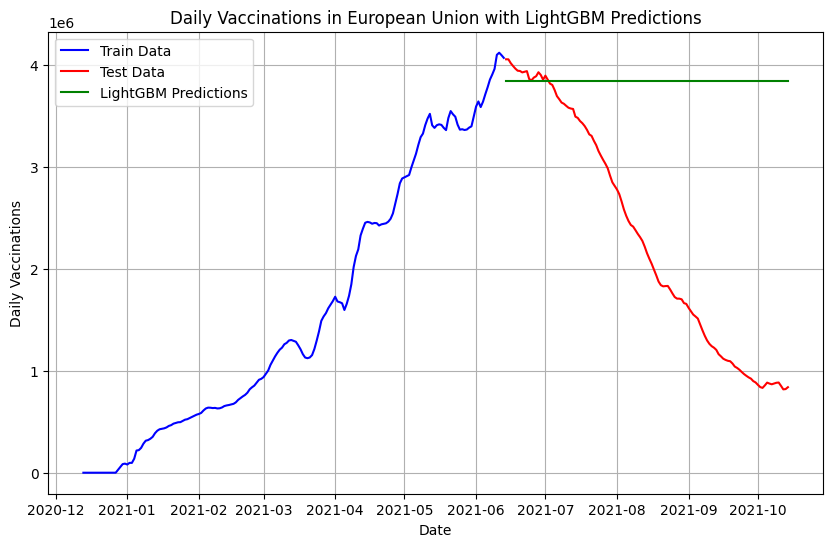

Training and testing LightGBM for North America


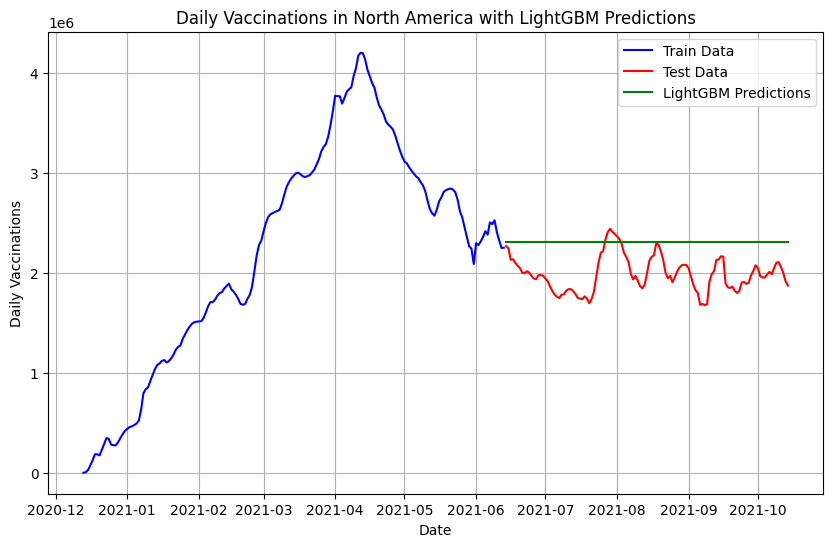

Training and testing LightGBM for Oceania


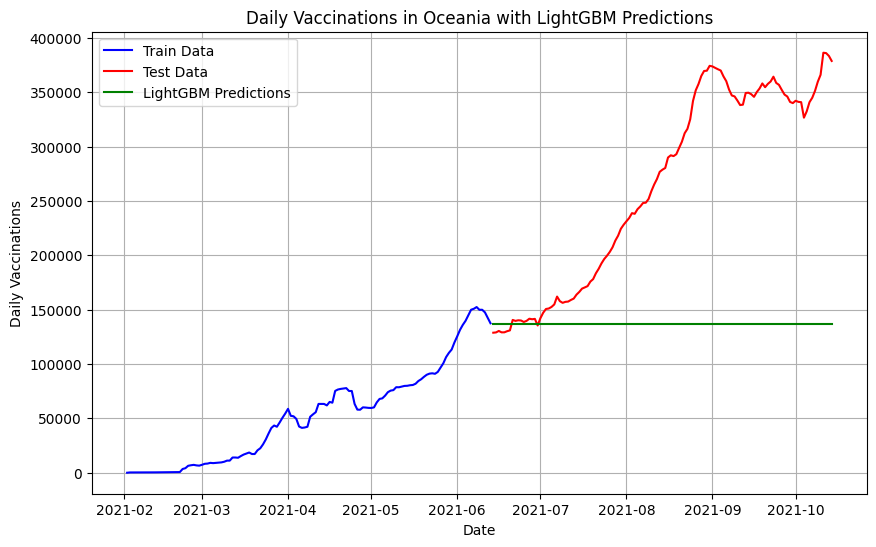

Training and testing LightGBM for South America


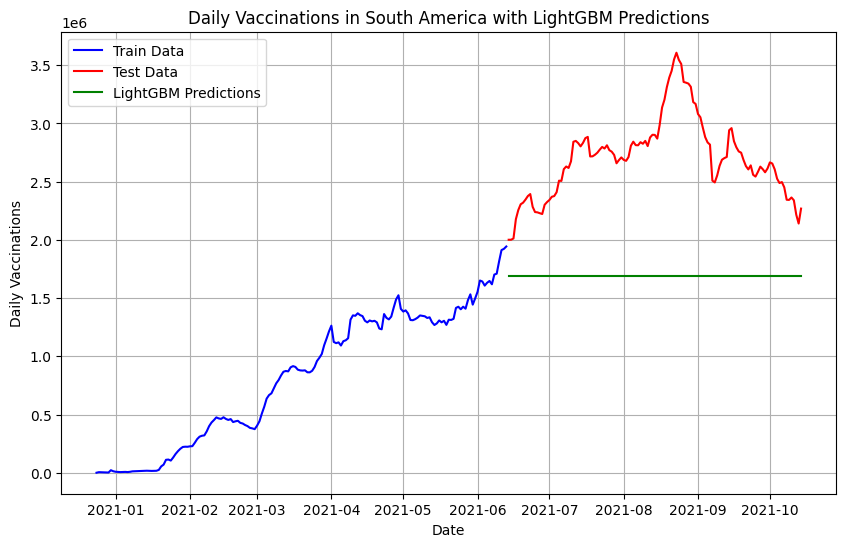

Training and testing LightGBM for World


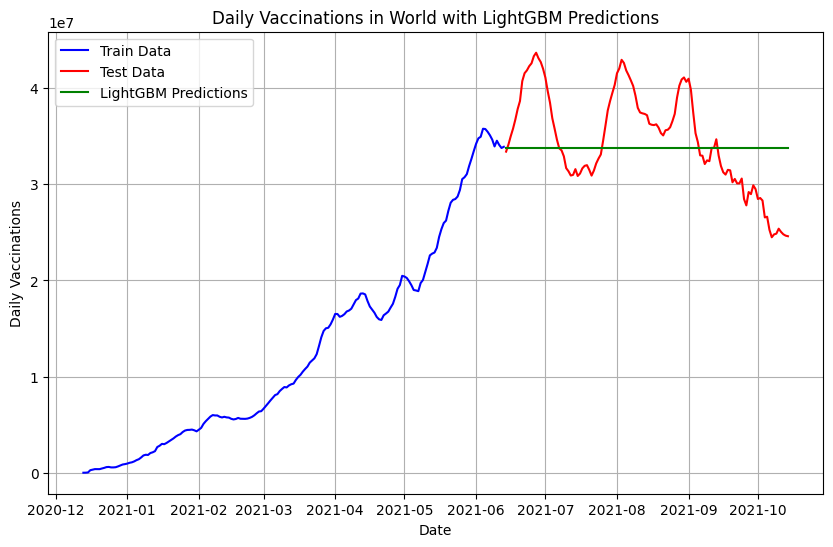

LightGBM RAE DataFrame:
                                  RAE
LightGBM_Africa_RAE          1.207255
LightGBM_Asia_RAE            1.023361
LightGBM_Europe_RAE          1.387884
LightGBM_European Union_RAE  1.506531
LightGBM_North America_RAE   2.399674
LightGBM_Oceania_RAE         1.546372
LightGBM_South America_RAE   3.976185
LightGBM_World_RAE           1.008661

LightGBM MSLE DataFrame:
                                  MSLE
LightGBM_Africa_MSLE          0.424872
LightGBM_Asia_MSLE            0.034503
LightGBM_Europe_MSLE          0.417816
LightGBM_European Union_MSLE  0.719101
LightGBM_North America_MSLE   0.031370
LightGBM_Oceania_MSLE         0.492857
LightGBM_South America_MSLE   0.229749
LightGBM_World_MSLE           0.023034

LightGBM MASE DataFrame:
                                   MASE
LightGBM_Africa_MASE          42.658272
LightGBM_Asia_MASE            16.320769
LightGBM_Europe_MASE          37.051898
LightGBM_European Union_MASE  48.737958
LightGBM_North America_MASE    

In [ ]:
# train and  test for LightGBM for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test and turn off all LightGBM  warnings

import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # Turn off LightGBM warnings

lightgbm_continent_rae = {}
lightgbm_continent_msle = {}
lightgbm_continent_mase = {}
lightgbm_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing LightGBM for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for LightGBM
    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    # Create LightGBM model
    model = lgb.LGBMRegressor(verbose=-1)

    # Train the model
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, train_y)

    # Store the metrics
    lightgbm_continent_rae[f'LightGBM_{continent}_RAE'] = rae
    lightgbm_continent_msle[f'LightGBM_{continent}_MSLE'] = msle
    lightgbm_continent_mase[f'LightGBM_{continent}_MASE'] = mase
    lightgbm_continent_predictions[f'LightGBM_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='LightGBM Predictions')

    plt.title(f'Daily Vaccinations in {continent} with LightGBM Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
lightgbm_rae_df = pd.DataFrame.from_dict(lightgbm_continent_rae, orient='index', columns=['RAE'])
lightgbm_msle_df = pd.DataFrame.from_dict(lightgbm_continent_msle, orient='index', columns=['MSLE'])
lightgbm_mase_df = pd.DataFrame.from_dict(lightgbm_continent_mase, orient='index', columns=['MASE'])

print("LightGBM RAE DataFrame:")
print(lightgbm_rae_df)

print("\nLightGBM MSLE DataFrame:")
print(lightgbm_msle_df)

print("\nLightGBM MASE DataFrame:")
print(lightgbm_mase_df)


Training and testing Elastic Net for Africa


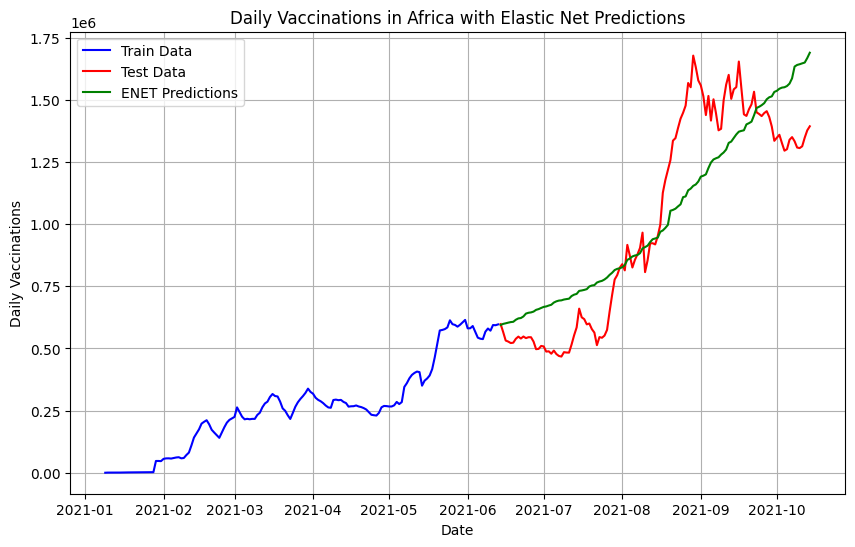

Training and testing Elastic Net for Asia


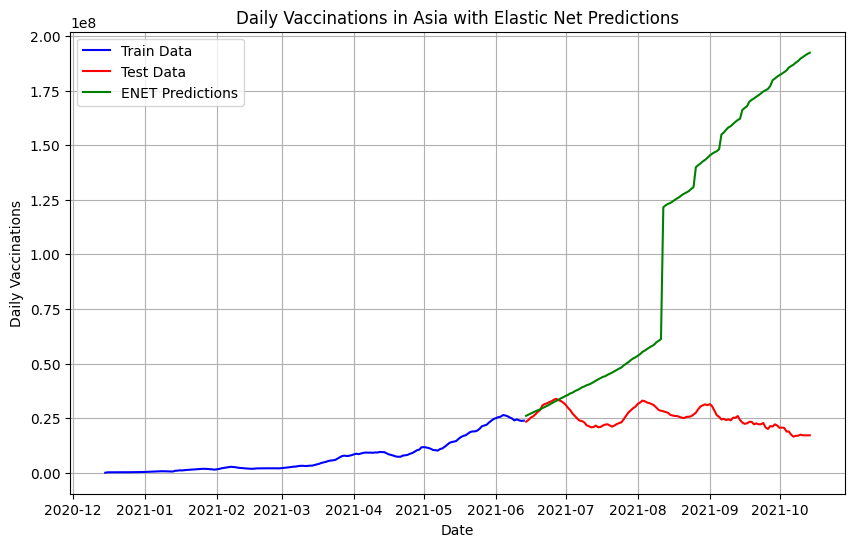

Training and testing Elastic Net for Europe


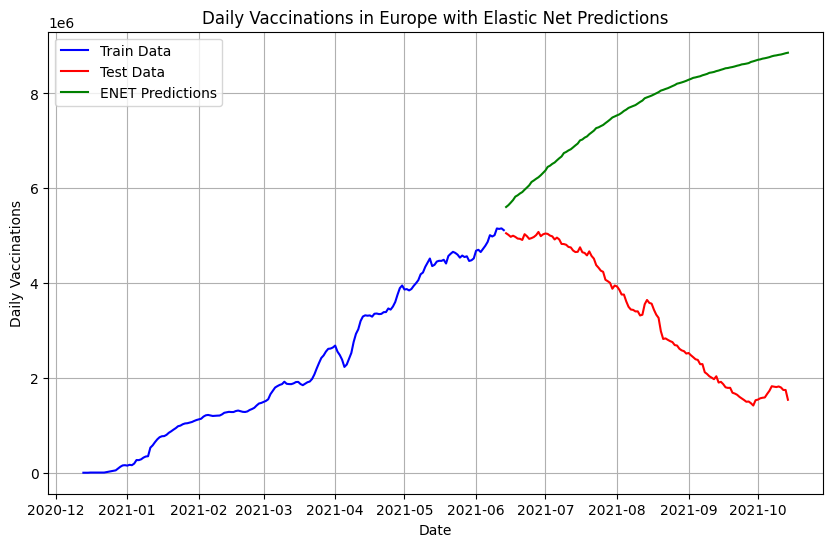

Training and testing Elastic Net for European Union


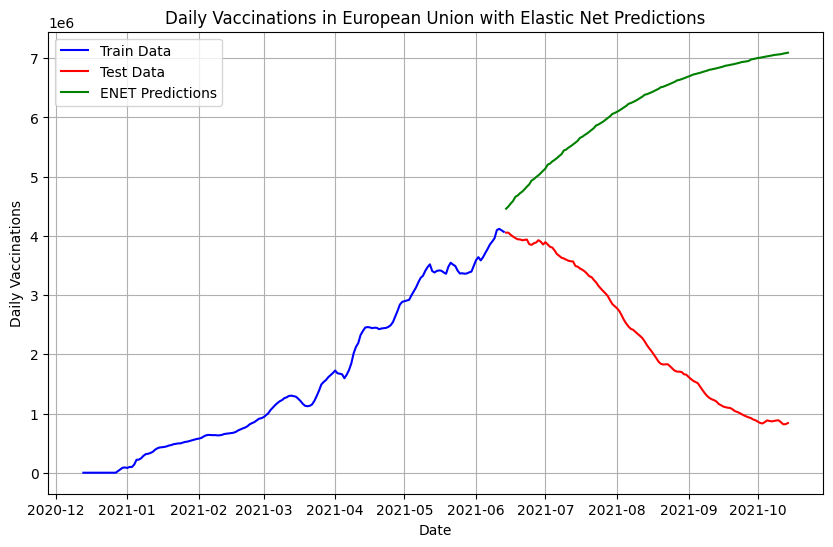

Training and testing Elastic Net for North America


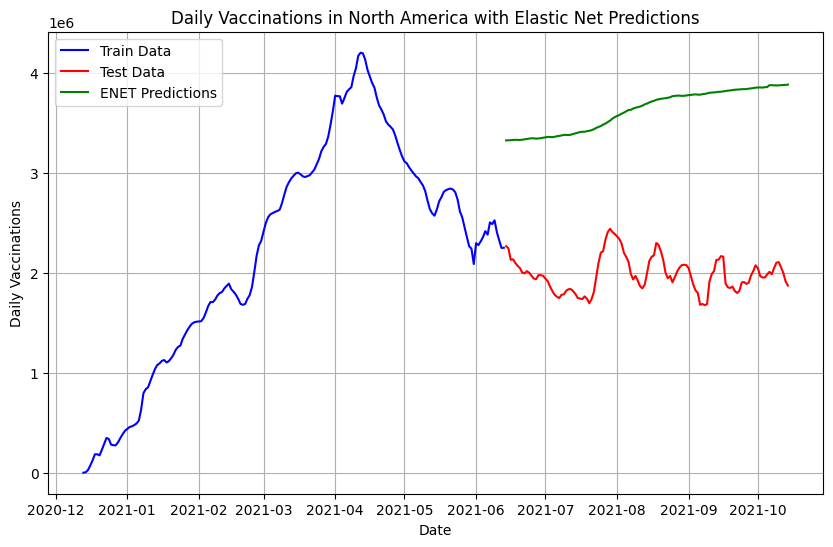

Training and testing Elastic Net for Oceania


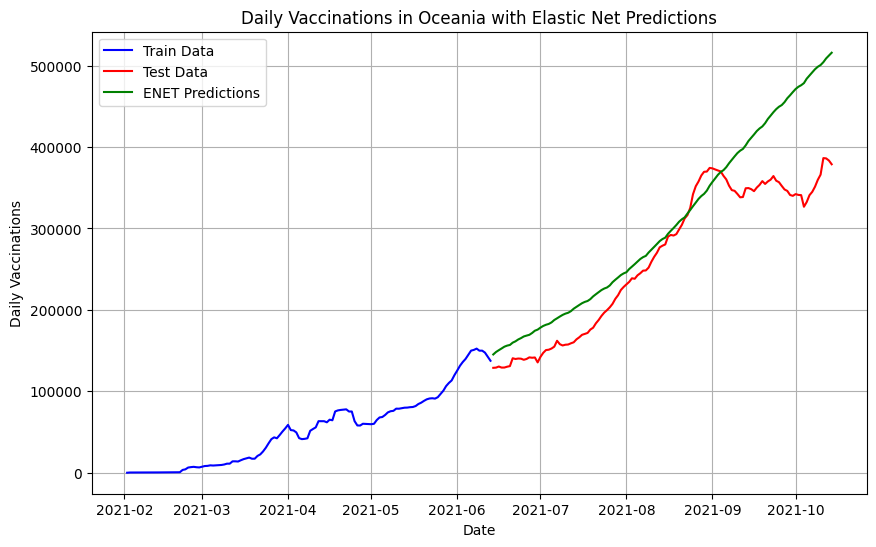

Training and testing Elastic Net for South America


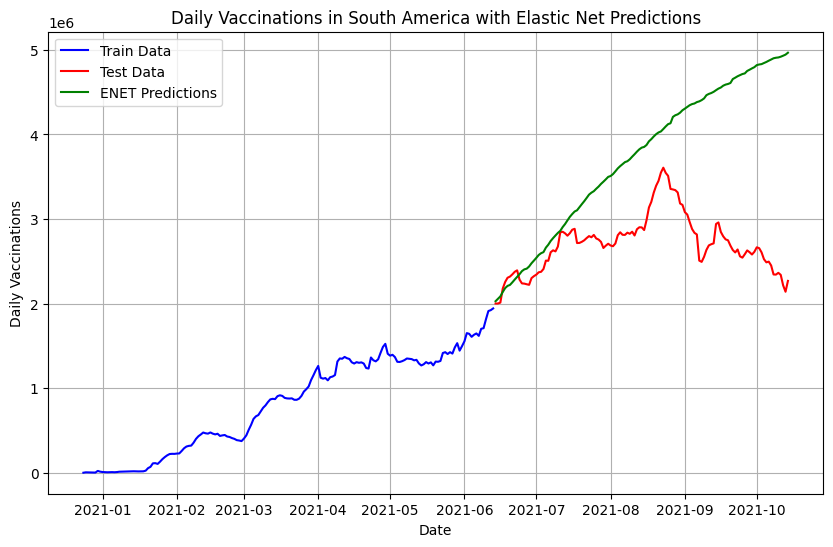

Training and testing Elastic Net for World


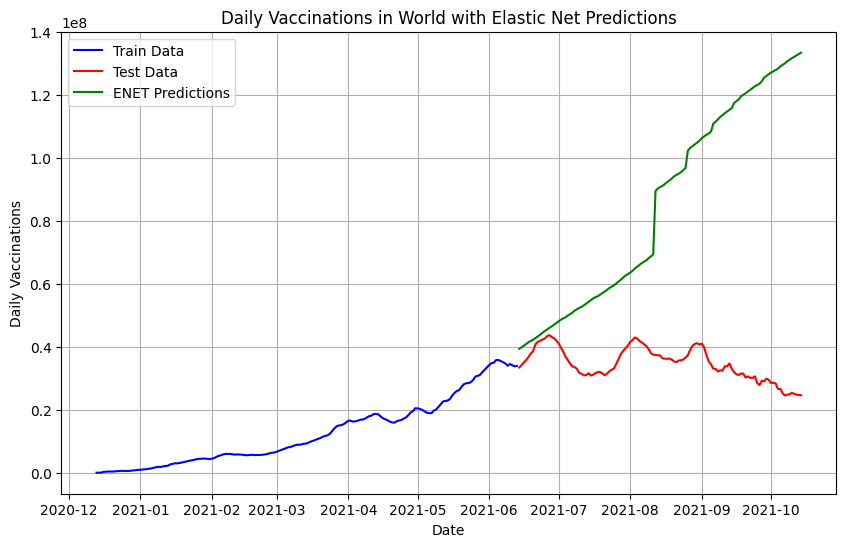

Elastic Net RAE DataFrame:
                               RAE
ENET_Africa_RAE           0.424963
ENET_Asia_RAE            20.756712
ENET_Europe_RAE           3.699529
ENET_European Union_RAE   3.742875
ENET_North America_RAE   11.878840
ENET_Oceania_RAE          0.553246
ENET_South America_RAE    4.046518
ENET_World_RAE           11.796352

Elastic Net MSLE DataFrame:
                              MSLE
ENET_Africa_MSLE          0.041994
ENET_Asia_MSLE            2.069554
ENET_Europe_MSLE          1.141708
ENET_European Union_MSLE  1.682302
ENET_North America_MSLE   0.375058
ENET_Oceania_MSLE         0.033332
ENET_South America_MSLE   0.143221
ENET_World_MSLE           0.940107

Elastic Net MASE DataFrame:
                                MASE
ENET_Africa_MASE           15.016035
ENET_Asia_MASE            331.032104
ENET_Europe_MASE           98.765132
ENET_European Union_MASE  121.086200
ENET_North America_MASE    34.662611
ENET_Oceania_MASE          23.402176
ENET_South America_MASE   

In [ ]:
# train and  test for Elastic Net (ENET)  for all continents and create  data frames for just Relative Absolute Error (RAE) by, Mean Squared Log Error (MSLE), and Mean Absolute Scaled Error (MASE) as a modelname_continent_metric also, modelname_continent_predictions for test data and show graph of prediction in the same graph of train and test

import pandas as pd
import matplotlib.pyplot as plt
enet_continent_rae = {}
enet_continent_msle = {}
enet_continent_mase = {}
enet_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing Elastic Net for {continent}")

    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    # Prepare the data for Elastic Net
    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    # Create Elastic Net model
    model = ElasticNet(alpha=0.1, l1_ratio=0.5)

    # Train the model
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, train_y)

    # Store the metrics
    enet_continent_rae[f'ENET_{continent}_RAE'] = rae
    enet_continent_msle[f'ENET_{continent}_MSLE'] = msle
    enet_continent_mase[f'ENET_{continent}_MASE'] = mase
    enet_continent_predictions[f'ENET_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot the train data in blue
    plt.plot(train_data['date'], train_data['daily_vaccinations'], color='blue', label='Train Data')

    # Plot the test data in red
    plt.plot(test_data['date'], test_data['daily_vaccinations'], color='red', label='Test Data')

    # Plot the predictions in green
    plt.plot(test_data['date'], predictions, color='green', label='ENET Predictions')

    plt.title(f'Daily Vaccinations in {continent} with Elastic Net Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
enet_rae_df = pd.DataFrame.from_dict(enet_continent_rae, orient='index', columns=['RAE'])
enet_msle_df = pd.DataFrame.from_dict(enet_continent_msle, orient='index', columns=['MSLE'])
enet_mase_df = pd.DataFrame.from_dict(enet_continent_mase, orient='index', columns=['MASE'])

print("Elastic Net RAE DataFrame:")
print(enet_rae_df)

print("\nElastic Net MSLE DataFrame:")
print(enet_msle_df)

print("\nElastic Net MASE DataFrame:")
print(enet_mase_df)


Training and testing Gaussian Process for Africa


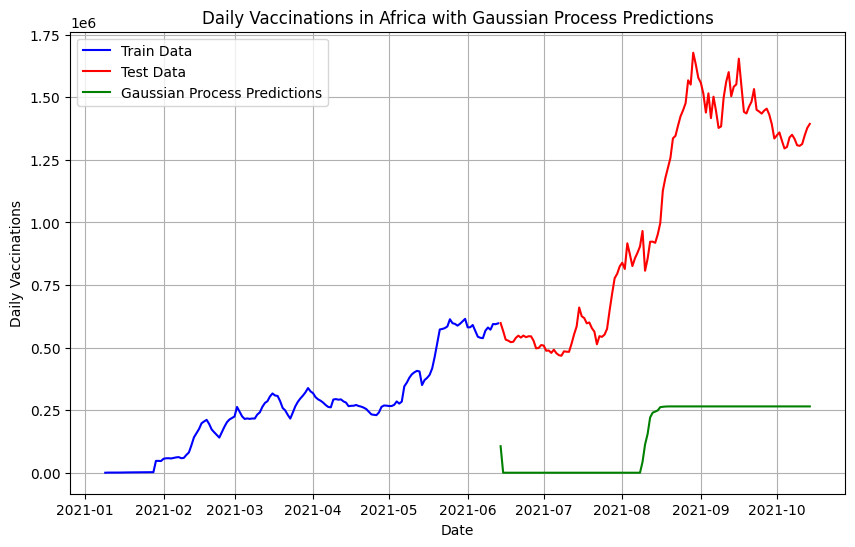

Training and testing Gaussian Process for Asia


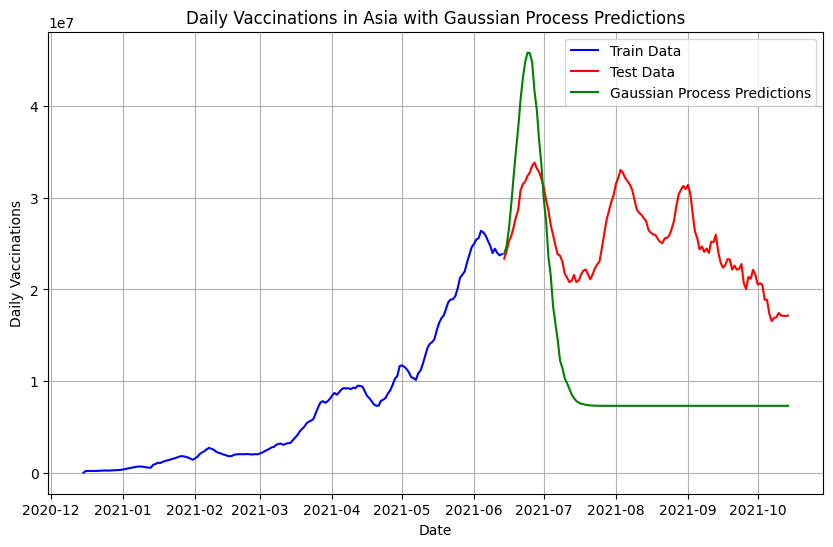

Training and testing Gaussian Process for Europe


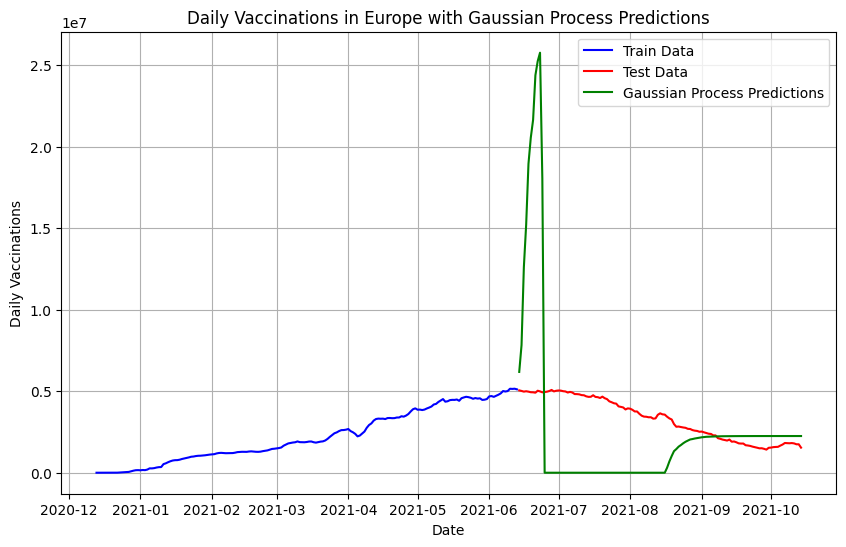

Training and testing Gaussian Process for European Union


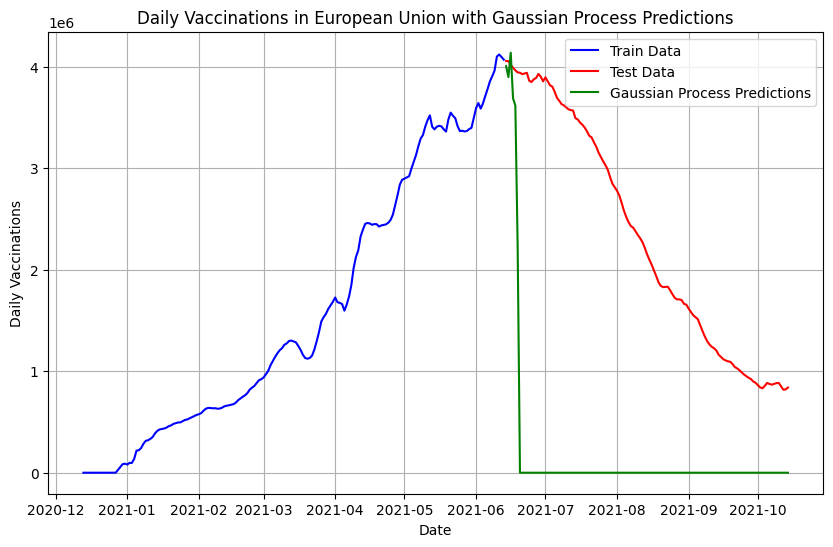

Training and testing Gaussian Process for North America


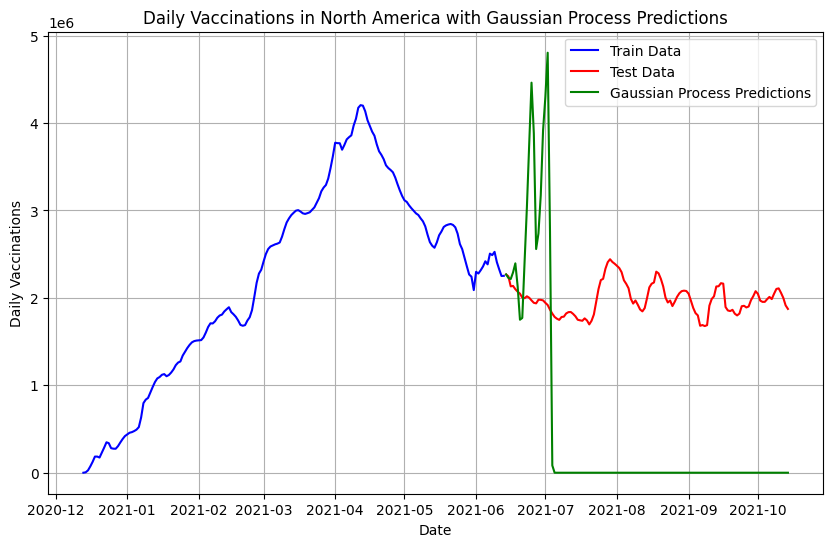

Training and testing Gaussian Process for Oceania


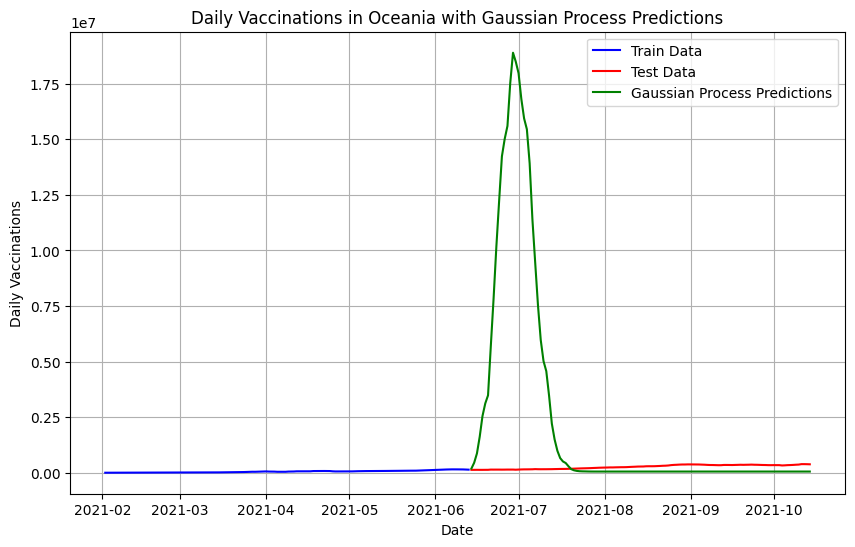

Training and testing Gaussian Process for South America


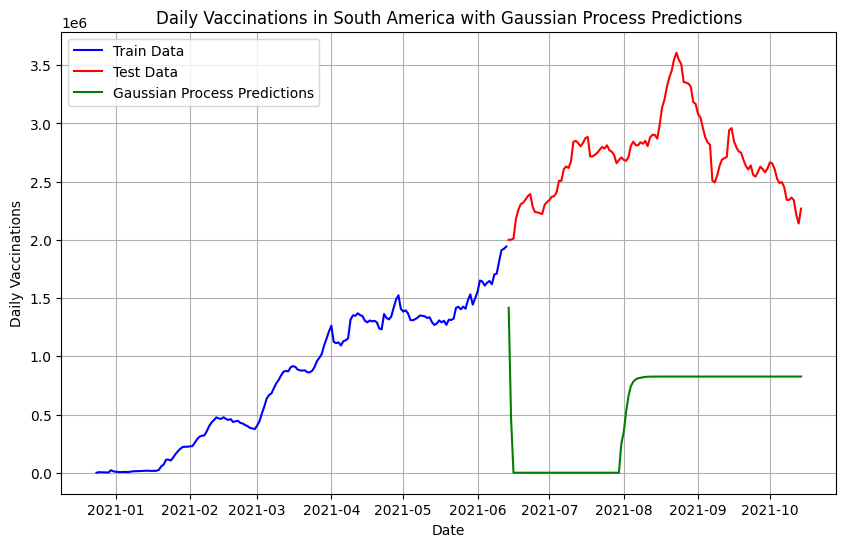

Training and testing Gaussian Process for World


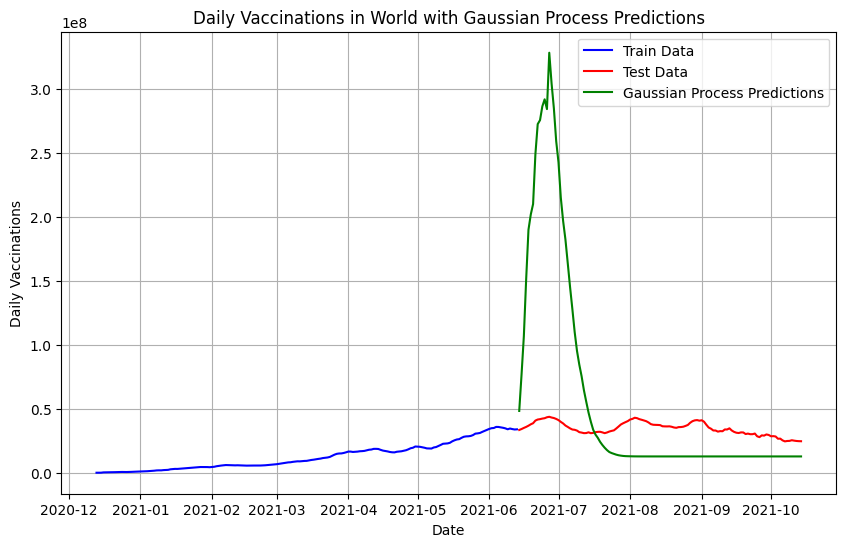

Gaussian Process RAE DataFrame:
                                RAE
GAUSS_Africa_RAE           2.237501
GAUSS_Asia_RAE             3.984259
GAUSS_Europe_RAE           2.840723
GAUSS_European Union_RAE   2.087055
GAUSS_North America_RAE   13.145063
GAUSS_Oceania_RAE         29.389421
GAUSS_South America_RAE    8.586232
GAUSS_World_RAE           12.021450

Gaussian Process MSLE DataFrame:
                                 MSLE
GAUSS_Africa_MSLE           80.551806
GAUSS_Asia_MSLE              1.148396
GAUSS_Europe_MSLE          100.769689
GAUSS_European Union_MSLE  199.784443
GAUSS_North America_MSLE   174.360095
GAUSS_Oceania_MSLE           5.982517
GAUSS_South America_MSLE    80.582806
GAUSS_World_MSLE             1.230336

Gaussian Process MASE DataFrame:
                                  MASE
GAUSS_Africa_MASE            79.061985
GAUSS_Asia_MASE              63.541735
GAUSS_Europe_MASE            75.837863
GAUSS_European Union_MASE    67.518555
GAUSS_North America_MASE     38.357467


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error

# Define metric functions
def relative_absolute_error(y_true, y_pred):
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    return numerator / denominator

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    n = len(y_train)
    mae = np.mean(np.abs(y_true - y_pred))
    naive_mae = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    return mae / naive_mae

# Create dictionaries to store metrics and predictions
gauss_continent_rae = {}
gauss_continent_msle = {}
gauss_continent_mase = {}
gauss_continent_predictions = {}

for continent in df_continents['location'].unique():
    print(f"Training and testing Gaussian Process for {continent}")

    # Prepare train and test data
    train_data = train_dfs[continent].copy()
    test_data = test_dfs[continent].copy()

    train_X = train_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    train_y = train_data['daily_vaccinations'].values
    test_X = test_data[['day_of_year', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']].values
    test_y = test_data['daily_vaccinations'].values

    # Scale the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    train_X = scaler_X.fit_transform(train_X)
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1)).flatten()
    test_X = scaler_X.transform(test_X)
    test_y = scaler_y.transform(test_y.reshape(-1, 1)).flatten()

    # Create Gaussian Process model
    model = GaussianProcessRegressor()

    # Train the model
    model.fit(train_X, train_y)

    # Make predictions
    predictions = model.predict(test_X)

    # Inverse transform predictions and test_y for metrics
    predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    test_y = scaler_y.inverse_transform(test_y.reshape(-1, 1)).flatten()

    # Clip negative values for MSLE
    predictions = np.clip(predictions, 0, None)
    test_y = np.clip(test_y, 0, None)

    # Calculate metrics
    rae = relative_absolute_error(test_y, predictions)
    msle = mean_squared_log_error(test_y, predictions)
    mase = mean_absolute_scaled_error(test_y, predictions, scaler_y.inverse_transform(train_y.reshape(-1, 1)).flatten())

    # Store metrics and predictions
    gauss_continent_rae[f'GAUSS_{continent}_RAE'] = rae
    gauss_continent_msle[f'GAUSS_{continent}_MSLE'] = msle
    gauss_continent_mase[f'GAUSS_{continent}_MASE'] = mase
    gauss_continent_predictions[f'GAUSS_{continent}_predictions'] = predictions

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train_data['date'], train_data['daily_vaccinations'], label='Train Data', color='blue')
    plt.plot(test_data['date'], test_data['daily_vaccinations'], label='Test Data', color='red')
    plt.plot(test_data['date'], predictions, label='Gaussian Process Predictions', color='green')
    plt.title(f'Daily Vaccinations in {continent} with Gaussian Process Predictions')
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create DataFrames for RAE, MSLE, and MASE
gauss_rae_df = pd.DataFrame.from_dict(gauss_continent_rae, orient='index', columns=['RAE'])
gauss_msle_df = pd.DataFrame.from_dict(gauss_continent_msle, orient='index', columns=['MSLE'])
gauss_mase_df = pd.DataFrame.from_dict(gauss_continent_mase, orient='index', columns=['MASE'])

# Print DataFrames
print("Gaussian Process RAE DataFrame:")
print(gauss_rae_df)

print("\nGaussian Process MSLE DataFrame:")
print(gauss_msle_df)

print("\nGaussian Process MASE DataFrame:")
print(gauss_mase_df)


In [ ]:
#Future work is to focus on hybrid models such as ARIMA-LSTM and comparing LSTM and ARIMA side by side based on the differences, to be continued...